<h1> <b> Task: Data Preparation, Feature Engineering, and Modeling Using the Bank Marketing Dataset </b> </h1>

# Load Python Libraries

In [ ]:
pip install ucimlrepo plotly dython

In [ ]:
# Import All Libraries

# GENERAL
import sys
from packaging import version
import uuid
import pprint
# DATA
import numpy as np
import pandas as pd
import scipy.stats as stats

# VISULISATION
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dython.nominal import associations
import statsmodels.api as sm


# Data Repository
from ucimlrepo import fetch_ucirepo

# MACHINE LEARNING
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc, f1_score

In [ ]:
# Manage Versions

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
#Constants


# Test Ratio = 20%
TEST_PORTION = 0.2

# Random State
RANDOM_STATE = 42

# Target Column
TARGET_COL =  'y'


# Load Data


In [ ]:

def load_data_from_uci():

  '''Go to UC Irvine Machine Learning reposity and find the Data Set you like
  https://archive.ics.uci.edu/dataset/2/adult and then use Import
  in Python button and then Copy the Python Code into your Notebook
  to Load the Data
  '''

  # fetch dataset
  bank_marketing = fetch_ucirepo(id=222)

  # data (as pandas dataframes)
  input_features = bank_marketing.data.features
  target_feature = bank_marketing.data.targets
  return input_features, target_feature

input_features, target_feature = load_data_from_uci()

# **Data Understanding in Short**

## **Findings about Data**

In [ ]:
# Findings about the data

def summarize_data(data_input, data_target=None, stat=True):
  """provides a complete overview of the data including the number of columns, data type, missing values and descriptive statistics and the sub-category per category"""

  if data_target is not None:
    data = pd.concat([data_input, data_target], axis=1)
  else:
    data = data_input

  print("-"*50)
  print("""Preview of the data""")
  print("-"*50)

  print("\n\n")
  print(data.head().T)

  print("-"*50)
  print("""Summary of data columns: counts and dtype""")
  print("-"*50)

  print("\n\n")
  print(data.info())

  print("\n\n")
  print("-"*50)
  print("""Summary of number of NULLs per columns""")
  print("-"*50)
  print(data.isna().sum() )

  print("\n\n")
  print("-"*50)
  print("""Summary of Number of Duplicates in the Data""")
  print("-"*50)
  print(data.duplicated().sum() )

  if stat:
    print("\n\n")
    print("-"*50)
    print("""Summary of Statistics on Numerical Variables""")
    print("-"*50)
    print(data.select_dtypes(include=["int64", "float64"]).describe())

    print("\n\n")
    print("-"*50)
    print("""Summary of Statistics on Categorical Variables""")
    print("-"*50)

    for feature in data.select_dtypes(include=["object"]).columns.to_list()[:]:
      print("\n\n")
      print("-"*50)
      print(f"Summary of Statistics on Categorical Variables: {feature}")
      print("-"*50)
      print(data[feature].value_counts(normalize=True))
      print(f"## number of unique subfeatures: {data[feature].nunique()} ")
      print(data[feature].unique()[:5])




summarize_data(input_features, target_feature, stat=True)

--------------------------------------------------
Preview of the data
--------------------------------------------------



                      0           1             2            3       4
age                  58          44            33           47      33
job          management  technician  entrepreneur  blue-collar     NaN
marital         married      single       married      married  single
education      tertiary   secondary     secondary          NaN     NaN
default              no          no            no           no      no
balance            2143          29             2         1506       1
housing             yes         yes           yes          yes      no
loan                 no          no           yes           no      no
contact             NaN         NaN           NaN          NaN     NaN
day_of_week           5           5             5            5       5
month               may         may           may          may     may
duration            261

## **Visualization of Data**

It is necessary to inspect the distribution of the numerical variables. Skewed distributions are difficult for ML models to predict hence some transformations like log boxcox etc are necessary to normalize their distribution. Using the histogram and QQ plot, it is obvious that these distributions do not follow a normal distribution.

NB: day_of_week is a nomical categorical variable

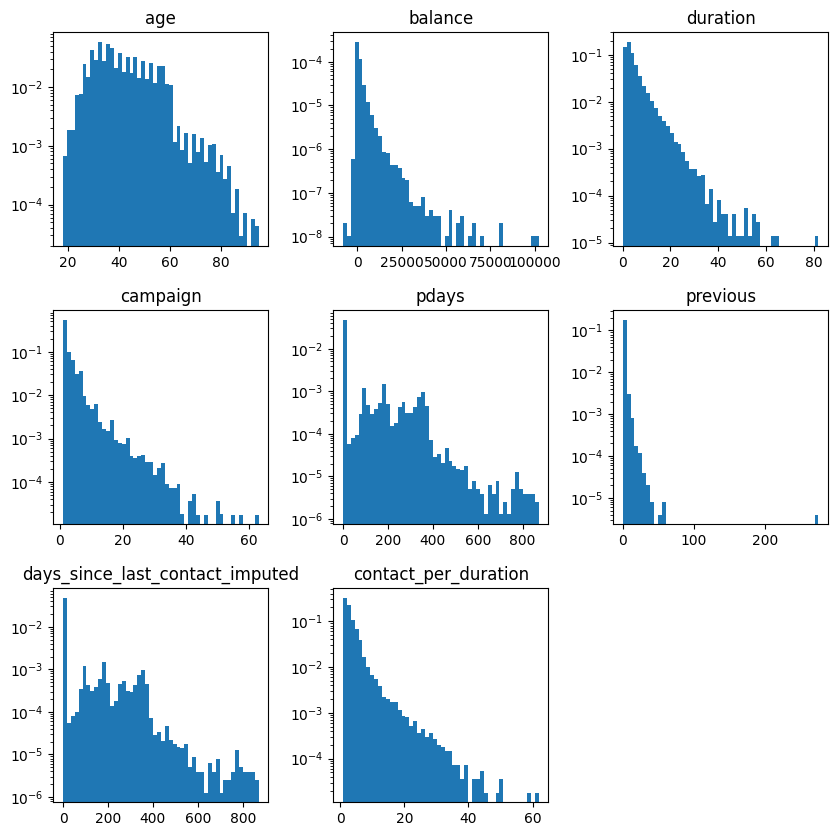

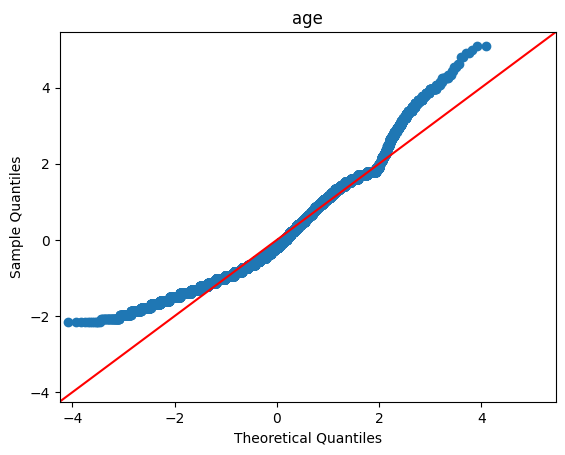

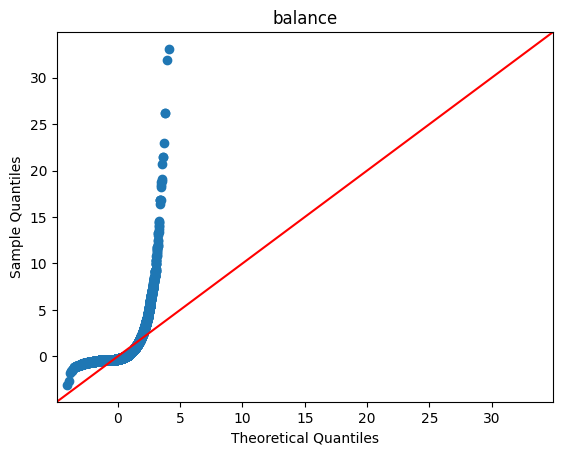

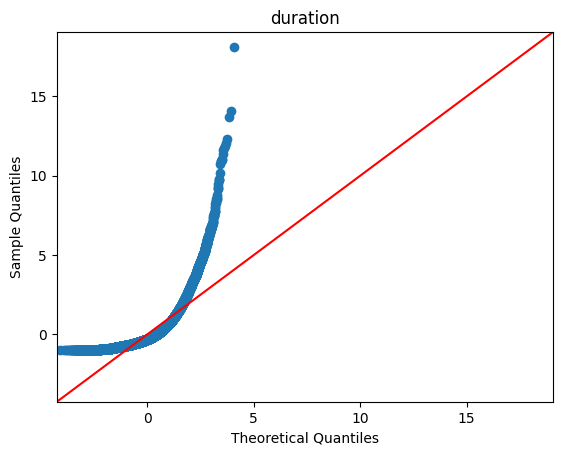

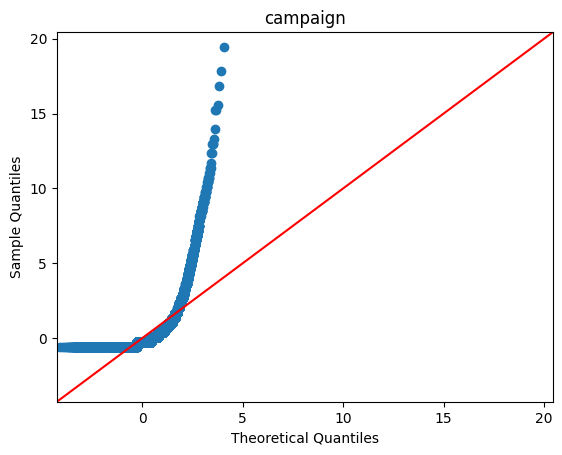

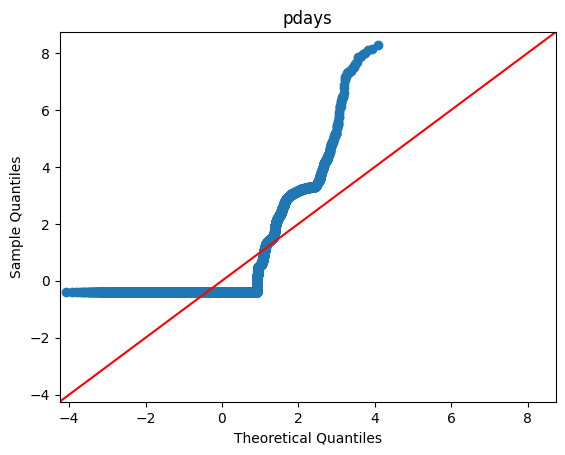

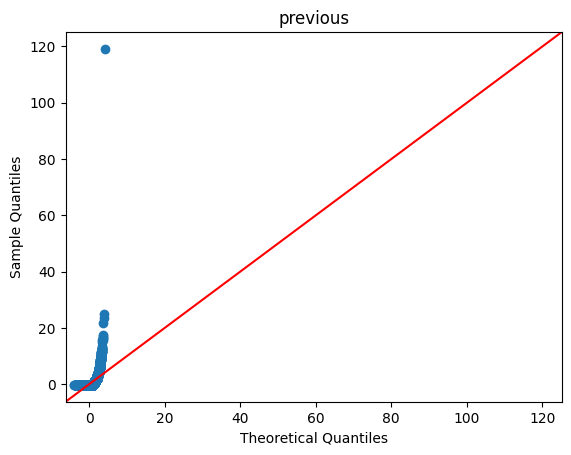

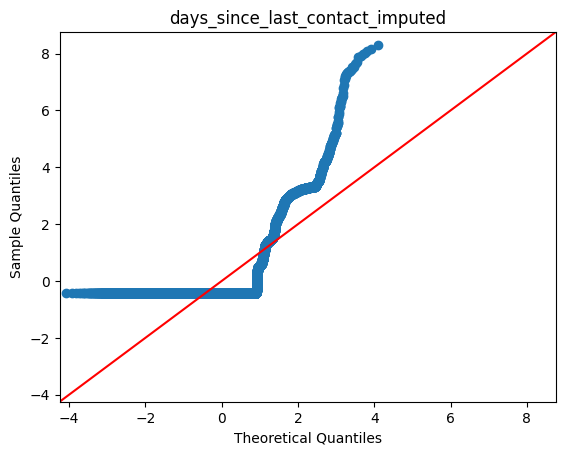

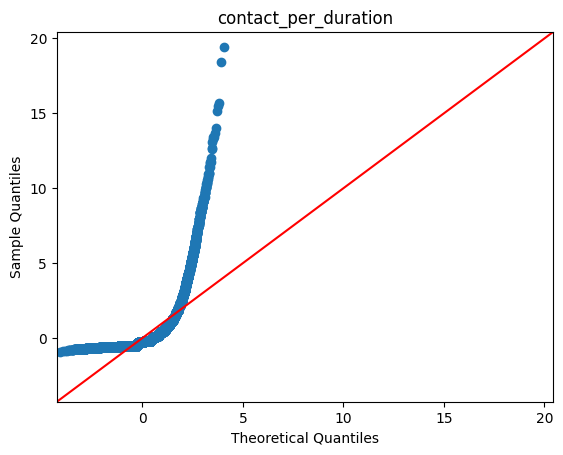

In [ ]:
def visualise_num_data(data_input, data_target=None, qq=True):
  data_input = data_input.copy()
  data_input["day_of_week"] = data_input["day_of_week"].astype("object")
  data_input["duration"] = data_input["duration"]/60
  data_input['days_since_last_contact_imputed'] = data_input['pdays'].replace(-1, 0)
  data_input["contact_per_duration"] = (data_input["campaign"]+1)/(data_input["duration"]/60+1)
  if data_target is not None:
    data = pd.concat([data_input, data_target], axis=1)
  else:
    data = data_input

  data.select_dtypes(include=["int64", "float64"]).hist(figsize=(10, 10), bins=50, density=True, grid=False, log=True)
  plt.show()
  print("\n")

  if qq:
    for feature in data.select_dtypes(include=["int64", "float64"]).columns.to_list():
      sm.qqplot(data[feature], line ='45',fit=True,dist=stats.norm)
      # sm.qqplot(np.log1p(data[feature]), line ='45',fit=True,dist=stats.norm) # log transformed
      plt.title(f"{feature}")
      plt.show()
      print("\n")

input_features, target_feature = load_data_from_uci()

visualise_num_data(input_features, target_feature)

## **Finding Relevance of Features: Correlations**

To avert the curse of dimensionality, we can drop the weakly correlated input features with the output feature. We can drop in this case the contact, age, default columns.

The previous contact information has been captured by the 'previously_contacted' and 'days_since_last_contact_imputed' columns, hence these two columns can be dropped. Also a new in_debt column has been aded

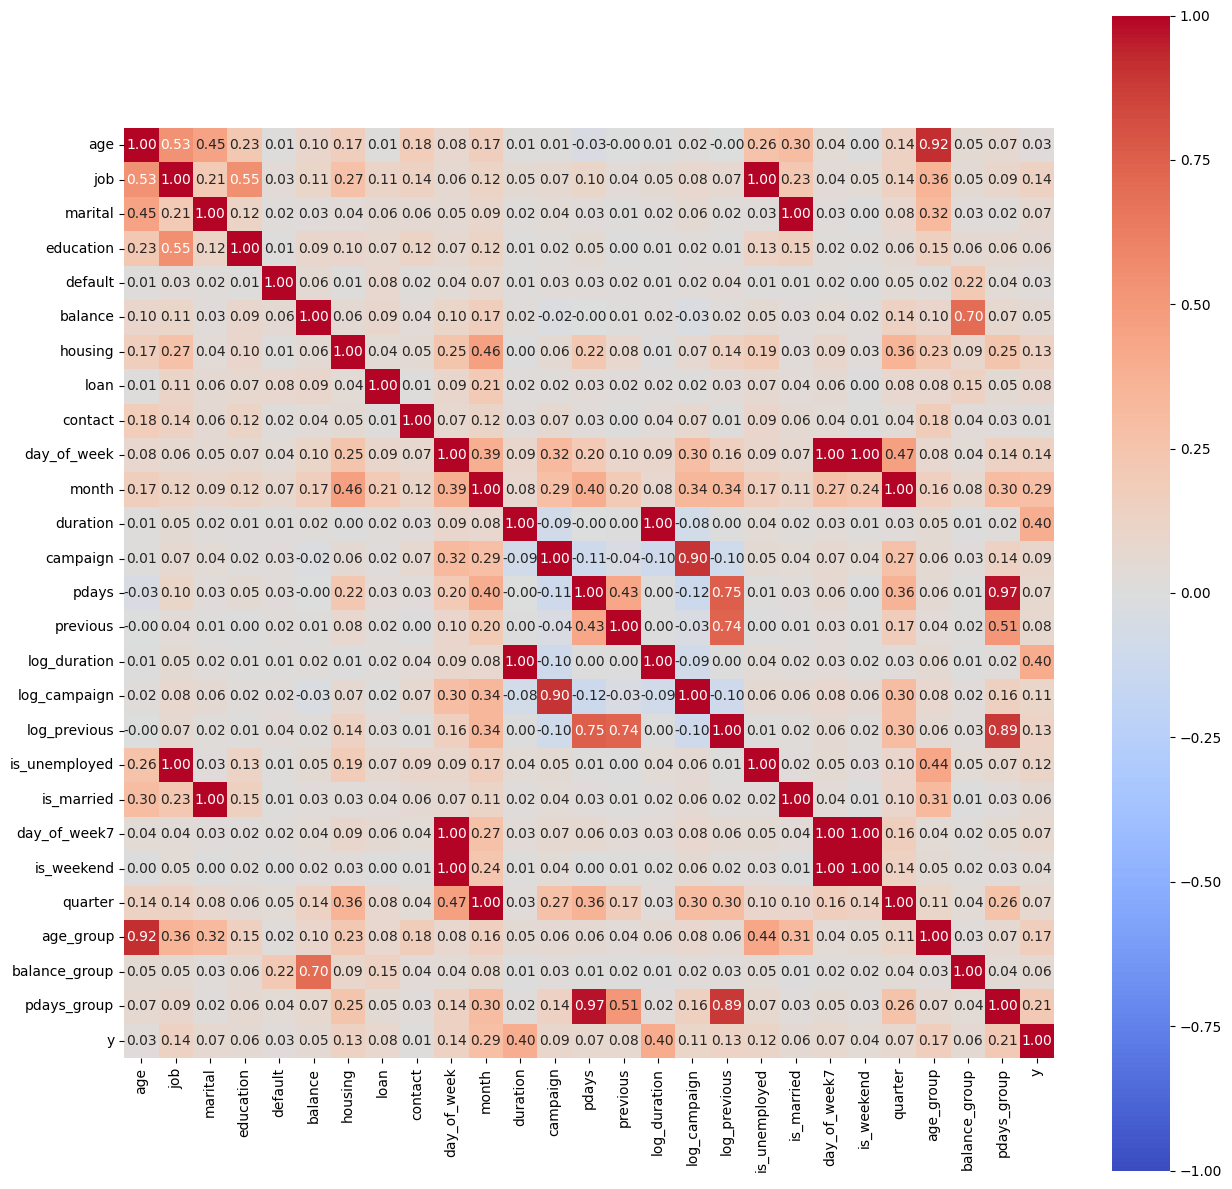

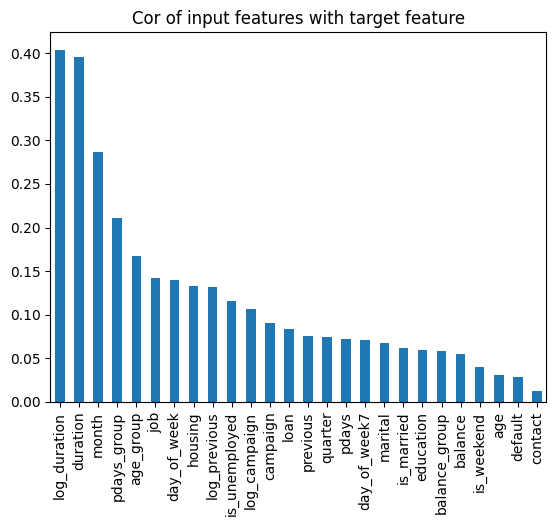

In [ ]:
from pandas.plotting import scatter_matrix

def map_to_weekday(day):
    return ((day - 1) % 7) + 1

def correlations_features(data_input, data_target=None, informative = True):
  """
  calculate the correlations btetween all the features; irrespective of data type and makes a heatplot.
  It also makes a plot of the correlation  of input features with the target variable.
  A pairplot of the variable numerical features is also made.
  """
  data_input = data_input.copy()
  data_input["day_of_week"] = data_input["day_of_week"].astype("object")
  data_input["duration"] = data_input["duration"]/60
  data_input["log_duration"] = np.log1p(data_input["duration"]/60)
  data_input["log_campaign"] = np.log1p(data_input["campaign"])
  data_input["log_previous"] = np.log1p(data_input["previous"])
  # data_input['previously_contacted'] = (data_input['pdays'] != -1).astype(object)
  # data_input['days_since_last_contact_imputed'] = data_input['pdays'].replace(-1, 0)
  # data_input["in_debt"] = (data_input["balance"] < 0.).astype(object)
  data_input["is_unemployed"] = data_input["job"].isin(["unemployed", "student", "retired"]).astype(object)
  data_input["is_married"] = (data_input["marital"] == "married").astype(object)
  data_input["day_of_week7"] = data_input["day_of_week"].apply(map_to_weekday).astype("object")
  data_input["is_weekend"] = data_input["day_of_week7"].isin([6, 7]).astype(object)
  # Map each month to its respective quarter
  month_to_quarter = {
    'jan': '1st quarter', 'feb': '1st quarter', 'mar': '1st quarter',
    'apr': '2nd quarter', 'may': '2nd quarter', 'jun': '2nd quarter',
    'jul': '3rd quarter', 'aug': '3rd quarter', 'sep': '3rd quarter',
    'oct': '4th quarter', 'nov': '4th quarter', 'dec': '4th quarter'
  }

  data_input['quarter'] = data_input['month'].map(month_to_quarter)
  bins = [0, 20, 30, 45, 60, np.inf]
  labels = ['<20', '20-30', '30-45', '45-60', '60+']
  data_input['age_group'] = pd.cut(data_input['age'], bins=bins, labels=labels, right=False)

  bins = [-float('inf'), -10000, -5000, 0, 20000, 40000, float('inf')]
  labels = ['Extremely Negative','Very Negative', 'Negative', 'Low', 'Medium', 'High']

  # Bin the balance values
  data_input['balance_group'] = pd.cut(data_input['balance'], bins=bins, labels=labels, right=False)

  bins = [-1, 0, 200, 400, float('inf')]
  labels = ['Bin1', 'Bin2', 'Bin3', 'Bin4']
  # Bin the balance values
  data_input['pdays_group'] = pd.cut(data_input['pdays'], bins=bins, labels=labels, right=False)

  if data_target is not None:
    data = pd.concat([data_input, data_target], axis=1)
  else:
    data = data_input
  data = data.drop(columns=["poutcome"])
  data = data.dropna(axis=0)
  cat_col = data.select_dtypes(include=["object"]).columns.to_list()

  num_col = data.select_dtypes(include=["int64", "float64"]).columns.to_list()

  assoc = associations(data, nominal_columns= cat_col, numerical_columns=num_col, nom_nom_assoc="cramer", num_num_assoc="pearson", nom_num_assoc="correlation_ratio", plot=True, cmap = "coolwarm", figsize = (15, 15))
  # print(assoc["corr"].loc["income"])
  print("\n\n\n")

  if informative:
    plt.figure()
    assoc["corr"].loc["y"].drop("y").sort_values(ascending=False).plot(kind="bar")
    plt.title("Cor of input features with target feature")
    plt.show()

  # print("\n\n\n")
  # scatter_matrix(data.select_dtypes(include=["int64", "float64"]), figsize=(15, 15))
  # plt.show()
  return assoc["corr"]

input_features, target_feature = load_data_from_uci()

assoc = correlations_features(input_features, target_feature)


# **Data Preparation**

1. Integrate Data
2. Select Data
3. Format & Clean Data
4. Construct Data

## **1. Integrate Data (Enrich Data)**

Here, we combine input and traget features into one composite dataFrame


In [ ]:
input_features, target_feature = load_data_from_uci()

Xy = pd.concat([input_features, target_feature], axis = 1)
Xy.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


## **2. Select Data**

#### data cleaning
The poutcome feature is dominated by nulls, hence going forward, it has been dropped. In a later section, outliers were taken out of the data

In [ ]:
# Adding a 'uuid' column with a unique identifier for each row
Xy['uuid'] = [uuid.uuid4() for _ in range(len(Xy))]
print(f"{Xy['uuid'].nunique()} vs {Xy.shape[0]} rows")


45211 vs 45211 rows


In [ ]:
Xy.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,uuid
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no,eeee5346-8412-4247-b086-d2c4a3aae6e8
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no,7fbb363d-1621-4b14-927e-a16af1022f39
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no,caf0a0c4-7226-4cfc-aea1-729543eb8618
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no,edd15e03-0393-451a-9658-c0f994f9d0d4
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no,cd99a8b1-6b9a-40b7-9415-19335855d8d7


In [ ]:
# dropping null rows and poutcome column
Xy.drop(columns=["poutcome"], inplace=True)
Xy.dropna(axis=0, inplace=True)
Xy.isna().sum()


age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
y              0
uuid           0
dtype: int64

## Split data into test and train set

Here, we used stratified split to ensure we maintain the class ratio of the original data in both the test and train sets

In [ ]:
Train_Xy, Test_Xy = train_test_split(Xy,
                                     test_size = TEST_PORTION,
                                     stratify=Xy[TARGET_COL],
                                     random_state = RANDOM_STATE)

Train_Xy_uuid = Train_Xy['uuid']
Test_Xy_uuid = Test_Xy['uuid']

# ratio of classes of target variable of the full dataset

Xy[TARGET_COL].value_counts(normalize = True)

y
no     0.853981
yes    0.146019
Name: proportion, dtype: float64

In [ ]:
# ratio of classes of target variable of the train set

Train_Xy[TARGET_COL].value_counts(normalize = True)

y
no     0.853994
yes    0.146006
Name: proportion, dtype: float64

In [ ]:
# ratio of classes of target variable of the test set

Test_Xy[TARGET_COL].value_counts(normalize = True)

y
no     0.853931
yes    0.146069
Name: proportion, dtype: float64

## **3. Format & Clean Data**
## Understanding data

Here, we study each feature column, to understand the data in this feature, and see how it can be feature engineered to improve model performance.

In [ ]:
Train_Xy.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'y', 'uuid'],
      dtype='object')

### Age column

The age distribution shows that there are some outliers (will be handled later). The most targeted age group is between 25 and 40 years



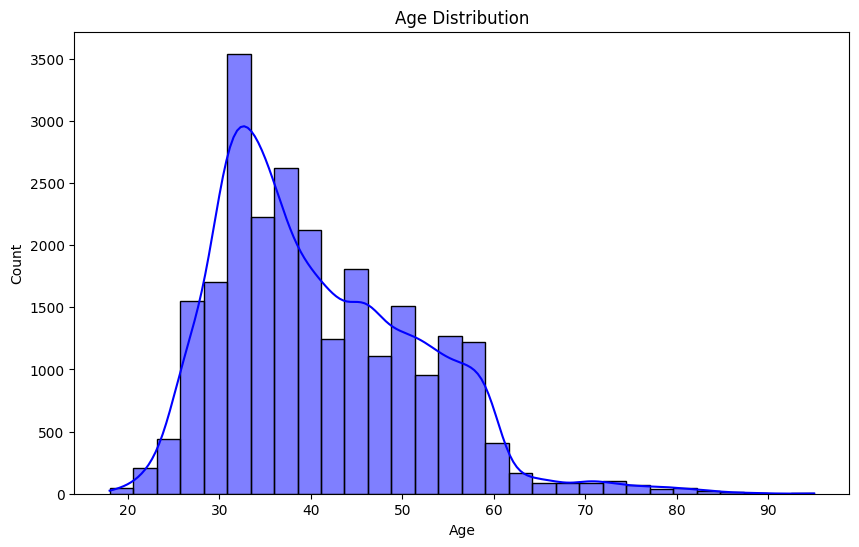

In [ ]:
# Plotting the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(Train_Xy['age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Sometimes grouping ages into bins can be informative.

<Axes: xlabel='age_group'>

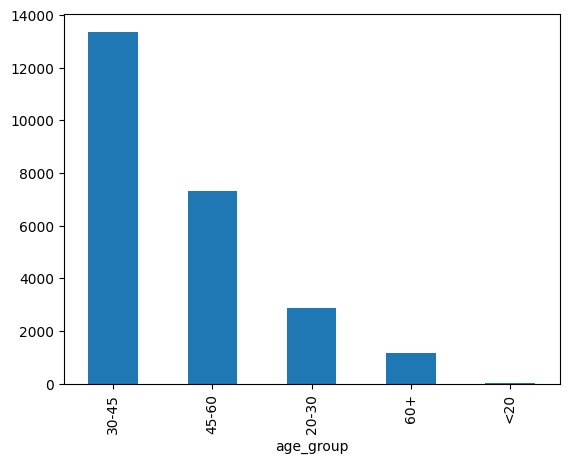

In [ ]:
# 2. Binning Age
bins = [0, 20, 30, 45, 60, np.inf]
labels = ['<20', '20-30', '30-45', '45-60', '60+']
Train_Xy['age_group'] = pd.cut(Train_Xy['age'], bins=bins, labels=labels, right=False)

Train_Xy['age_group'].value_counts().plot(kind='bar')

What is the interaction of age with other features? To answer this question, examine the plot below. Aside "age_group", there is a weak correlation between the age and the other feature variables hence we do not have to worry about multi-collinearity.

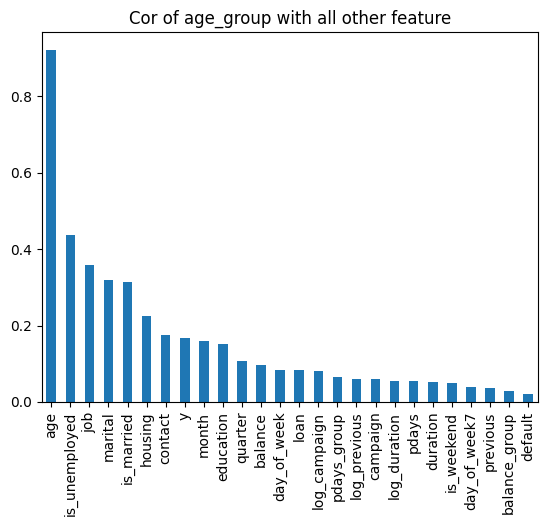

In [ ]:
plt.figure()
assoc.loc["age_group"].drop("age_group").sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of age_group with all other feature")
plt.show()

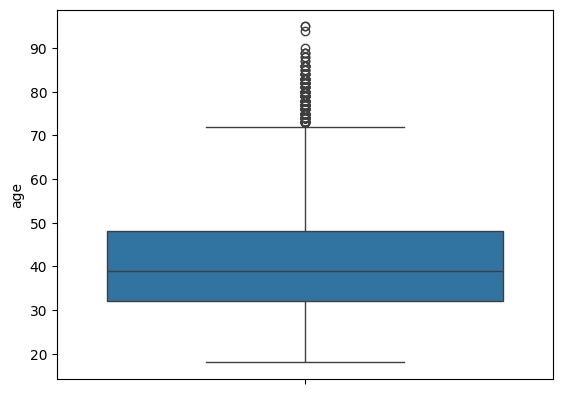

In [ ]:
sns.boxplot(Train_Xy["age"])
plt.show()

In [ ]:
Train_Xy.y = (Train_Xy.y == 'yes').astype(int)
global_churn = Train_Xy.y.mean()
global_churn

0.14600606673407482

using feature imporatnace metrics like risk ratio and difference (same info but in different ways), we show which features are more likely to subscribe. By interpreting these ratios, you can identify which features and categories are most relevant and influential for your target variable, helping you make better decisions in feature engineering and model building. From the calculations shown below. People below, 20 are mostly likely to susbcribe followed by 60+ and 20-30. The other group are less likely to subscribe



In [ ]:
Train_Xy['age_group'].value_counts()

age_group
30-45    13359
45-60     7329
20-30     2860
60+       1151
<20         26
Name: count, dtype: int64

In [ ]:
Train_Xy.groupby("age_group").y.agg(['mean', 'count'])

,mean,count
age_group,,
<20,0.384615,26
20-30,0.218881,2860
30-45,0.125833,13359
45-60,0.118707,7329
60+,0.367507,1151


In [ ]:
categorical = Train_Xy['age_group'].unique().to_list()
for c in categorical:
    print(c, type(c))
    df_group = Train_Xy[Train_Xy['age_group'] == c]['y'].agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn # postive more likely to subscribe
    df_group['risk'] = df_group['mean'] / global_churn # greater than one more likely to subscribe/equal to one, same risk as customer in the company
    print(df_group)
    print()
    print()

45-60 <class 'str'>
mean        0.118707
count    7329.000000
diff       -0.027300
risk        0.813024
Name: y, dtype: float64


30-45 <class 'str'>
mean         0.125833
count    13359.000000
diff        -0.020173
risk         0.861832
Name: y, dtype: float64


<20 <class 'str'>
mean      0.384615
count    26.000000
diff      0.238609
risk      2.634242
Name: y, dtype: float64


20-30 <class 'str'>
mean        0.218881
count    2860.000000
diff        0.072875
risk        1.499123
Name: y, dtype: float64


60+ <class 'str'>
mean        0.367507
count    1151.000000
diff        0.221500
risk        2.517063
Name: y, dtype: float64




### Job column

In [ ]:
Train_Xy["job"].value_counts(normalize=True)

job
management       0.237048
technician       0.181759
blue-collar      0.178888
admin.           0.113448
services         0.084853
retired          0.053711
self-employed    0.037654
entrepreneur     0.032194
unemployed       0.031062
housemaid        0.028150
student          0.021234
Name: proportion, dtype: float64

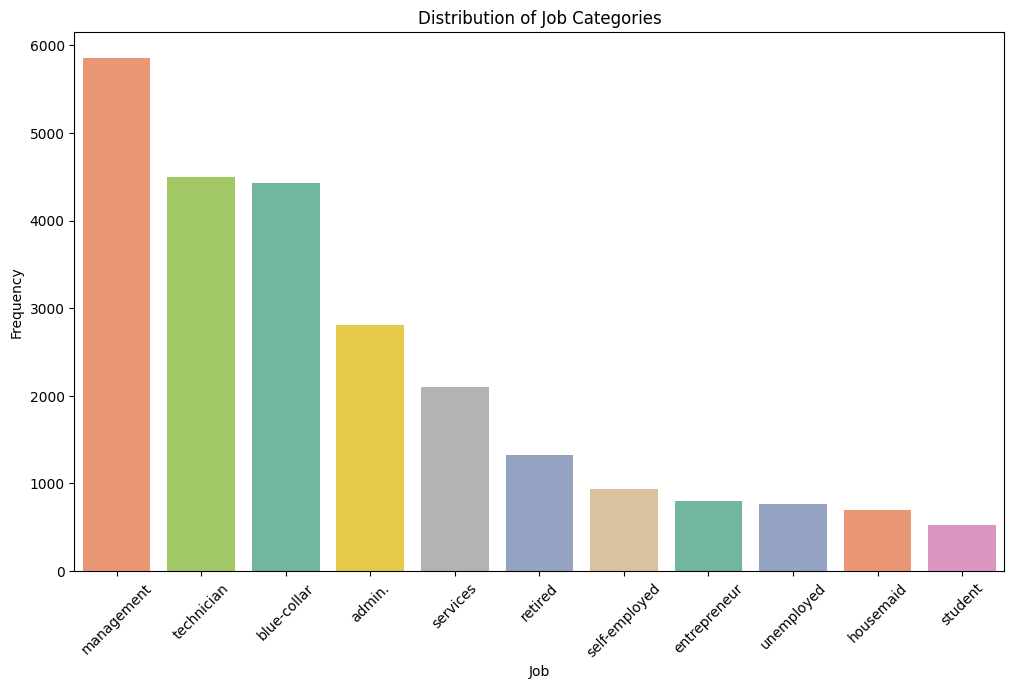

In [ ]:
# Create the bar plot adjusting for the seaborn update

order = Train_Xy['job'].value_counts().index

plt.figure(figsize=(12, 7))
ax = sns.countplot(x='job', data=Train_Xy, hue='job', order = order, palette='Set2', dodge=False)

# Check if the legend exists before removing it
legend = ax.get_legend()
if legend:
    legend.remove()

# Add title and labels
plt.title('Distribution of Job Categories')
plt.xlabel('Job')
plt.ylabel('Frequency')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

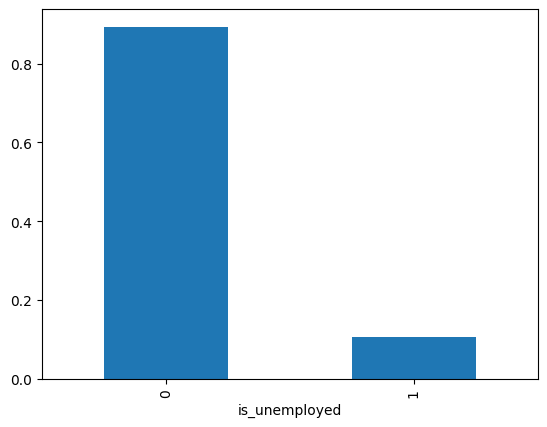

In [ ]:
Train_Xy["is_unemployed"] = Train_Xy["job"].isin(["unemployed", "student", "retired"]).astype(int)

Train_Xy["is_unemployed"].value_counts(normalize=True).plot(kind="bar")
plt.show()

The most correlated feature is age which tells you that whether a person has a job or not is influence by age (not too weakly).

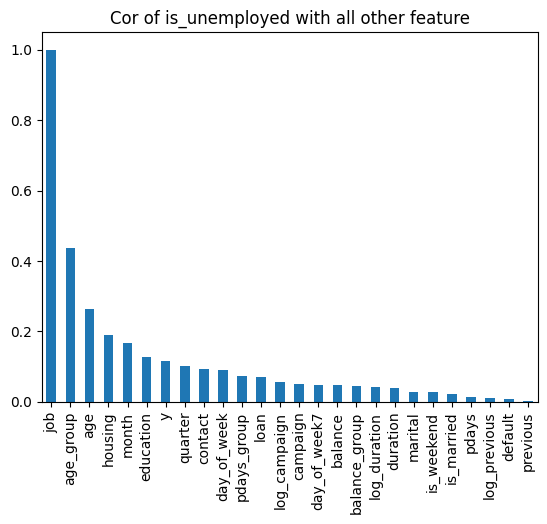

In [ ]:
plt.figure()
assoc.loc["is_unemployed"].drop(["is_unemployed"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of is_unemployed with all other feature")
plt.show()

### Marital column

In [ ]:
Train_Xy["marital"].value_counts(normalize=True)

marital
married     0.601941
single      0.282764
divorced    0.115295
Name: proportion, dtype: float64

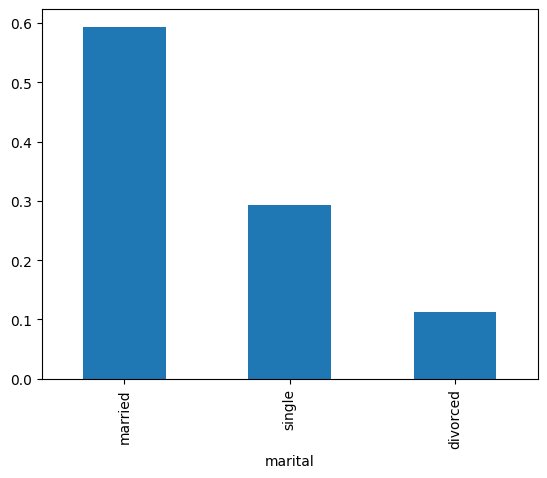

In [ ]:
Train_Xy["marital"].value_counts(normalize=True).plot(kind="bar")
plt.show()

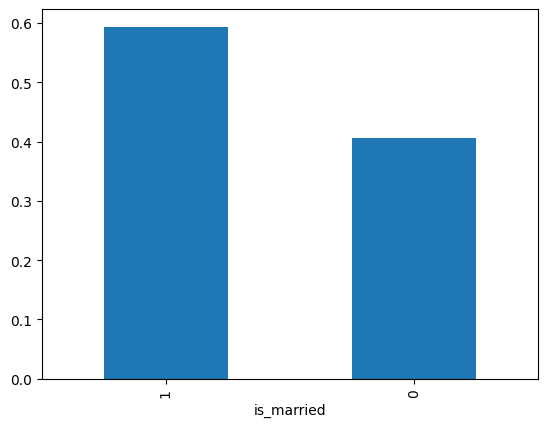

In [ ]:
Train_Xy["is_married"] = (Train_Xy["marital"] == "married").astype(int)

Train_Xy["is_married"].value_counts(normalize=True).plot(kind="bar")
plt.show()

Age is the largest influencing factor

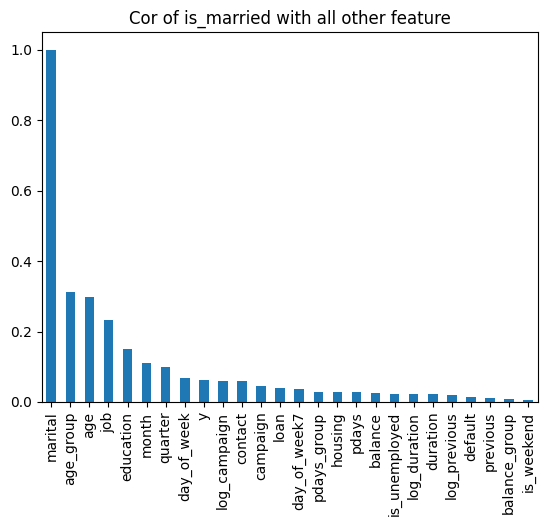

In [ ]:
plt.figure()
assoc.loc["is_married"].drop(["is_married"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of is_married with all other feature")
plt.show()

### Education column

In [ ]:
Train_Xy["education"].value_counts(normalize=True)

education
secondary    0.519191
tertiary     0.343458
primary      0.137351
Name: proportion, dtype: float64

### Default column

In [ ]:
Train_Xy["default"].value_counts(normalize=True)

default
no     0.983943
yes    0.016057
Name: proportion, dtype: float64

### Balance column

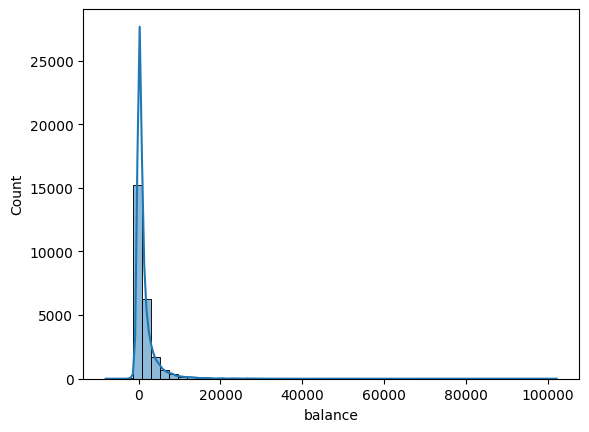

In [ ]:
sns.histplot(Train_Xy["balance"], bins=50, kde=True, log_scale=False)
plt.show()

<Axes: xlabel='balance_group'>

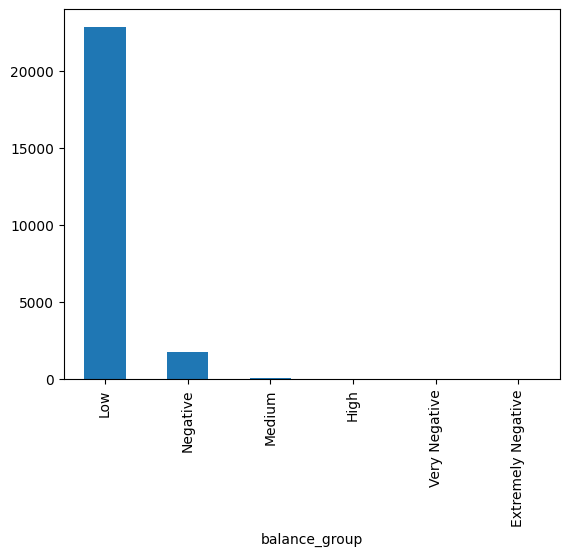

In [ ]:
# Define the bins and labels
bins = [-float('inf'), -10000, -5000, 0, 20000, 40000, float('inf')]
labels = ['Extremely Negative','Very Negative', 'Negative', 'Low', 'Medium', 'High']

# Bin the balance values
Train_Xy['balance_group'] = pd.cut(Train_Xy['balance'], bins=bins, labels=labels, right=False)


Train_Xy['balance_group'].value_counts().plot(kind='bar')

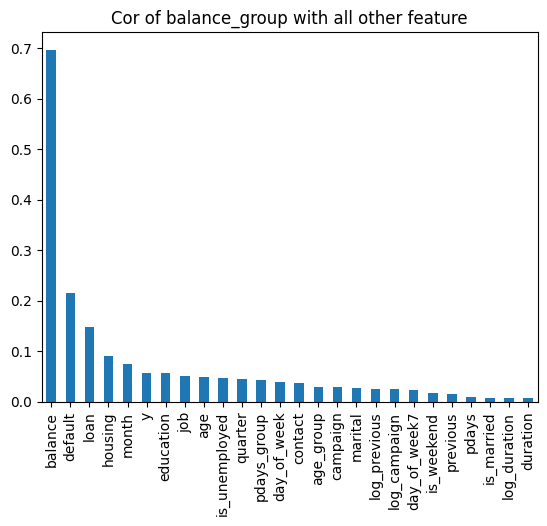

In [ ]:
plt.figure()
assoc.loc["balance_group"].drop(["balance_group"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of balance_group with all other feature")
plt.show()

In [ ]:
# Train_Xy.loc[:,['balance']][Train_Xy['balance_group']=='Bin1'].min()

In [ ]:
# mask = (Train_Xy["balance"] > -500) & (Train_Xy["balance"] < 0.)

# Train_Xy["small_debt"] = Train_Xy["balance"][mask]

# sns.histplot(Train_Xy["small_debt"], bins=50, kde=True)
# plt.show()

In [ ]:
# mask = (Train_Xy["balance"] >= -1000) & (Train_Xy["balance"] < -500.)

# Train_Xy["medium_debt"] = Train_Xy["balance"][mask]

# sns.histplot(Train_Xy["medium_debt"], bins=50, kde=True)
# plt.show()

In [ ]:
# mask = (Train_Xy["balance"] < -1000)

# Train_Xy["high_debt"] = Train_Xy["balance"][mask]

# sns.histplot(Train_Xy["high_debt"], bins=50, kde=True)
# plt.show()


In [ ]:
# mask = (Train_Xy["balance"] >= 0) & (Train_Xy["balance"] < 10000.)

# Train_Xy["middle_income"] = Train_Xy["balance"][mask]

# sns.histplot(Train_Xy["middle_income"], bins=50, kde=True)
# plt.show()

In [ ]:
# mask = (Train_Xy["balance"] >= 10000)

# Train_Xy["above_middle_income"] = Train_Xy["balance"][mask]

# sns.histplot(Train_Xy["above_middle_income"], bins=50, kde=True)
# plt.show()

In [ ]:
# mask.value_counts(normalize=True).plot(kind="bar")

In [ ]:
# Train_Xy["in_debt"] = (Train_Xy["balance"] < 0.).astype(int)
# Train_Xy["in_debt"].value_counts(normalize=True).plot(kind="bar")
# plt.show()

In [ ]:
# sns.boxplot(Train_Xy["balance"])
# plt.show()

In [ ]:
# from scipy.stats import boxcox

# #sns.histplot(boxcox(Train_Xy["balance"]+8120), bins=50, kde=True)
# sns.histplot(np.log1p(Train_Xy["balance"] + np.abs(Train_Xy["balance"])), bins=50, kde=True)

# plt.show()

### Housing column

In [ ]:
Train_Xy["housing"].value_counts(normalize=True)

housing
no     0.506289
yes    0.493711
Name: proportion, dtype: float64

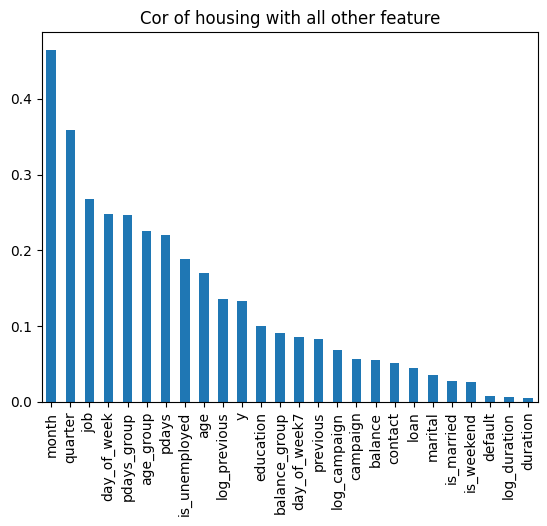

In [ ]:
plt.figure()
assoc.loc["housing"].drop(["housing"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of housing with all other feature")
plt.show()

### Loan column


In [ ]:
Train_Xy["loan"].value_counts(normalize=True)

loan
no     0.83547
yes    0.16453
Name: proportion, dtype: float64

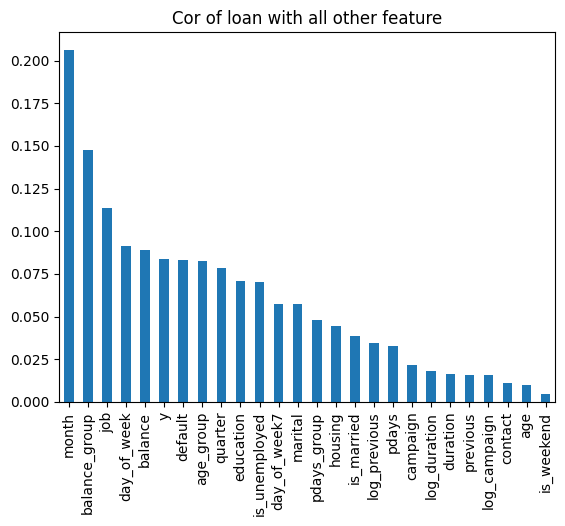

In [ ]:
plt.figure()
assoc.loc["loan"].drop(["loan"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of loan with all other feature")
plt.show()

### Contact column

In [ ]:
Train_Xy["contact"].value_counts(normalize=True)

contact
cellular     0.913893
telephone    0.086107
Name: proportion, dtype: float64

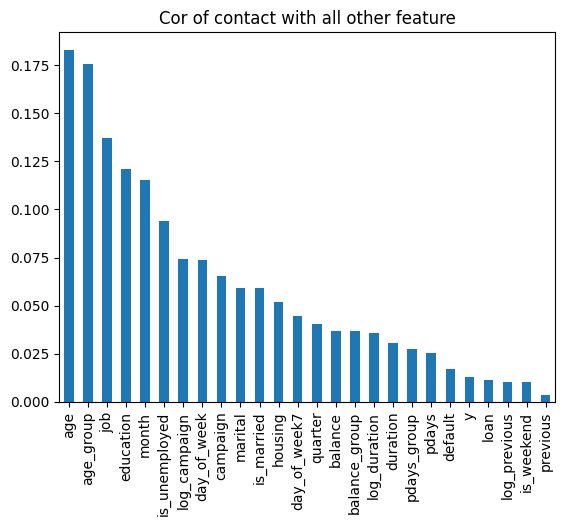

In [ ]:
plt.figure()
assoc.loc["contact"].drop(["contact"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of contact with all other feature")
plt.show()

### Day of Week column
It is unclear why day of the week should range between 0 and 31. First convert this to days of the week and further regouped them into weekends and weekdays

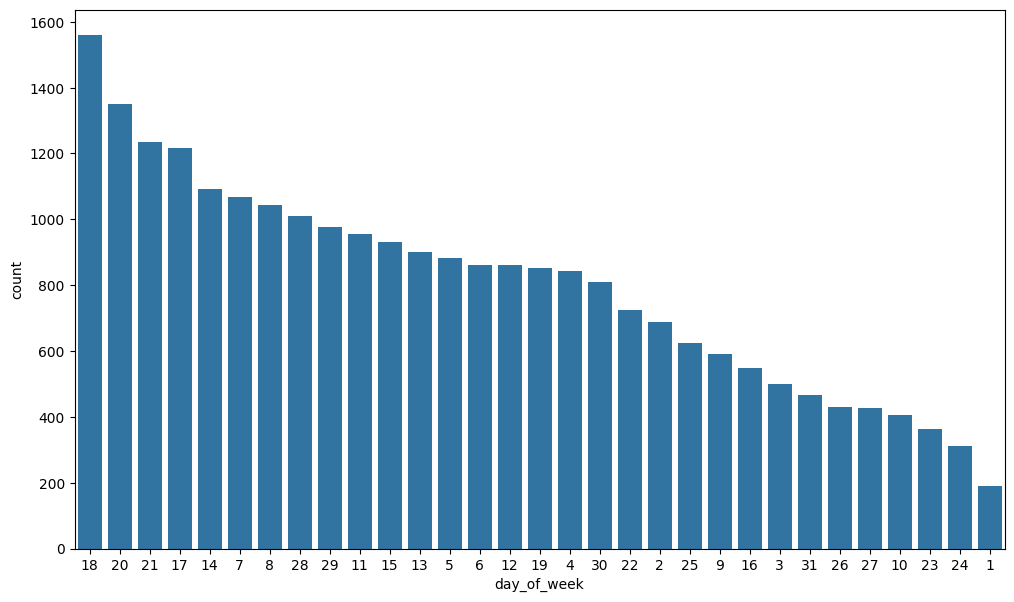

In [ ]:
Train_Xy["day_of_week"] = Train_Xy["day_of_week"].astype("object")

order = Train_Xy['day_of_week'].value_counts().index

plt.figure(figsize=(12, 7))
ax = sns.countplot(x='day_of_week', data=Train_Xy, order = order)

plt.show()


In [ ]:
def map_to_weekday(day):
    return ((day - 1) % 7) + 1

day = Train_Xy["day_of_week"].apply(map_to_weekday)
day.describe()

count    24725.000000
mean         4.113650
std          2.072975
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max          7.000000
Name: day_of_week, dtype: float64

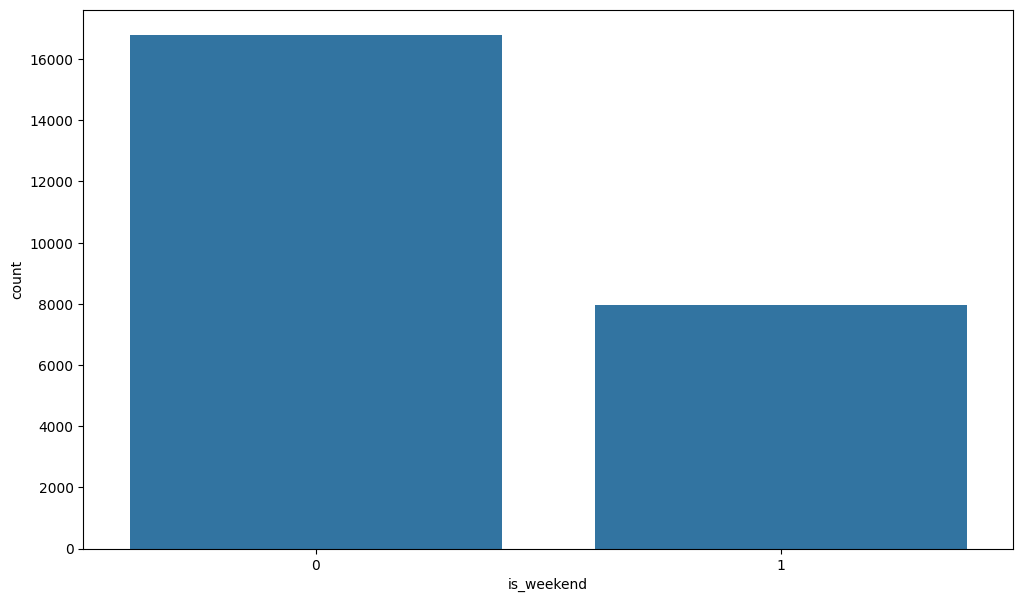

In [ ]:
Train_Xy["day_of_week"] = Train_Xy["day_of_week"].apply(map_to_weekday).astype("object")
Train_Xy["is_weekend"] = Train_Xy["day_of_week"].isin([6, 7]).astype(int)

# order = Train_Xy['day_of_week'].value_counts().index
order = Train_Xy['is_weekend'].value_counts().index

plt.figure(figsize=(12, 7))
# ax = sns.countplot(x='day_of_week', data=Train_Xy, order = order)
ax = sns.countplot(x='is_weekend', data=Train_Xy, order = order)

plt.show()


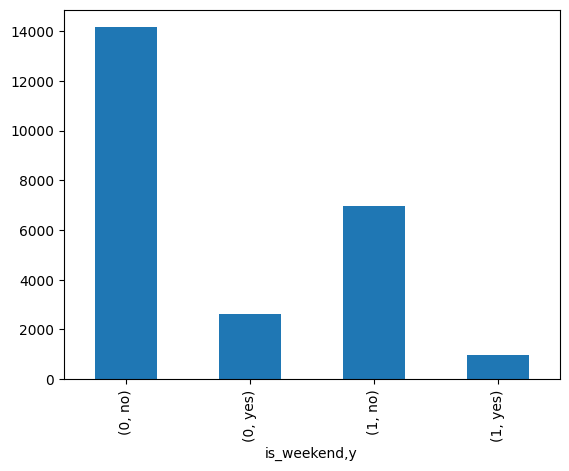

In [ ]:
Train_Xy.groupby("is_weekend")["y"].value_counts().plot(kind='bar')
plt.show()

We see more subscription within the weekdays than weekend on the weekend but we also see that there are more campaigns in the weekdays than there are on weekends

In [ ]:
Train_Xy.groupby("is_weekend")["campaign"].sum()

is_weekend
0    45088
1    23421
Name: campaign, dtype: int64

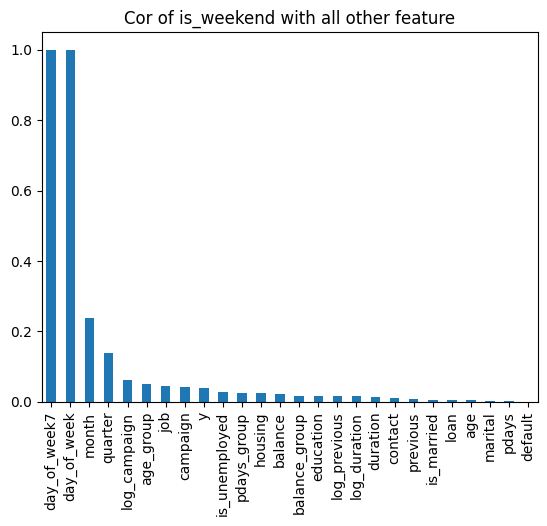

In [ ]:
plt.figure()
assoc.loc["is_weekend"].drop(["is_weekend"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of is_weekend with all other feature")
plt.show()

### Month column

This is last contact month of the year for each client. Its distrbution should correspond to those of a campaign

In [ ]:
Train_Xy["month"].value_counts(normalize=True)

month
jul    0.204328
aug    0.196481
may    0.179414
nov    0.121699
apr    0.091648
feb    0.082063
jan    0.041901
jun    0.024510
oct    0.020384
sep    0.016340
mar    0.014439
dec    0.006795
Name: proportion, dtype: float64

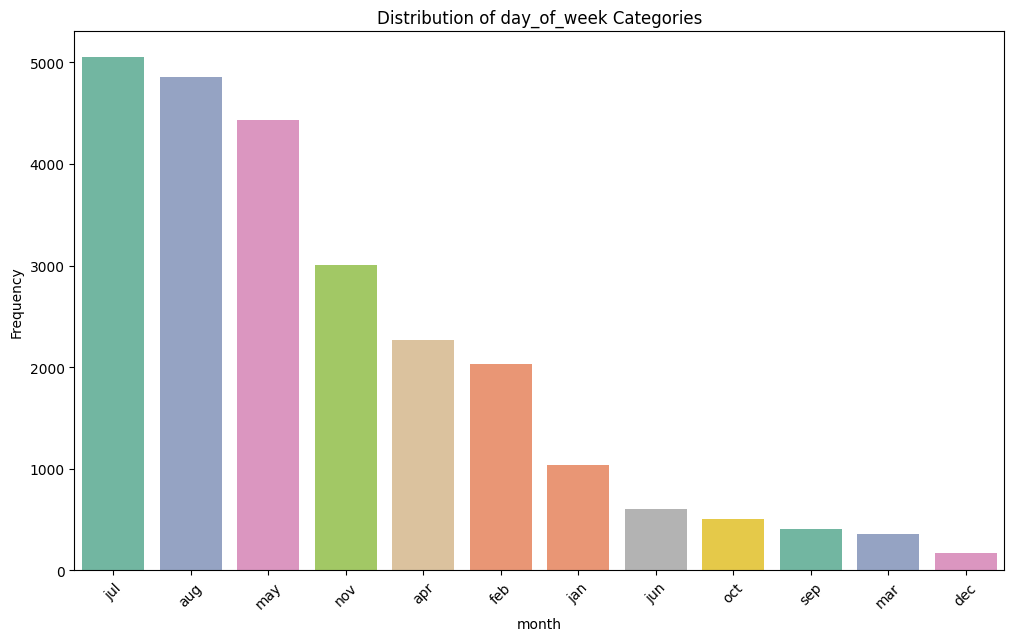

In [ ]:
# Create the bar plot adjusting for the seaborn update

order = Train_Xy['month'].value_counts().index

plt.figure(figsize=(12, 7))
ax = sns.countplot(x='month', data=Train_Xy, hue='month', order = order, palette='Set2', dodge=False)

# Check if the legend exists before removing it
legend = ax.get_legend()
if legend:
    legend.remove()

# Add title and labels
plt.title('Distribution of day_of_week Categories')
plt.xlabel('month')
plt.ylabel('Frequency')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

Does the month correlate with campaigns? It does if you look at the statistics below

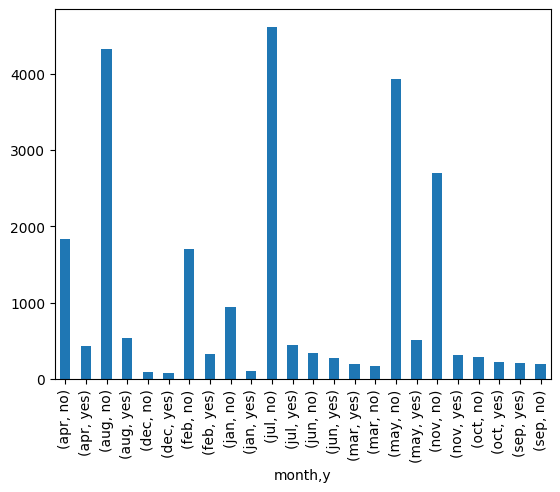

In [ ]:
Train_Xy.groupby("month")["y"].value_counts().plot(kind='bar')
plt.show()

The amount of yes or no scales with the campaign as shown below. This suggests that campaign is a better predictor for the number of subscriptions.

In [ ]:
Train_Xy.groupby("month")["campaign"].sum()

month
apr     4412
aug    19392
dec      381
feb     4819
jan     1728
jul    18293
jun     1110
mar      785
may    10312
nov     5767
oct      782
sep      728
Name: campaign, dtype: int64

let's group the months into 4 categories

In [ ]:
# Map each month to its respective quarter
month_to_quarter = {
    'jan': '1st quarter', 'feb': '1st quarter', 'mar': '1st quarter',
    'apr': '2nd quarter', 'may': '2nd quarter', 'jun': '2nd quarter',
    'jul': '3rd quarter', 'aug': '3rd quarter', 'sep': '3rd quarter',
    'oct': '4th quarter', 'nov': '4th quarter', 'dec': '4th quarter'
}

Train_Xy['quarter'] = Train_Xy['month'].map(month_to_quarter)

Train_Xy["quarter"].value_counts(normalize=True)


quarter
3rd quarter    0.417149
2nd quarter    0.295571
4th quarter    0.148878
1st quarter    0.138402
Name: proportion, dtype: float64

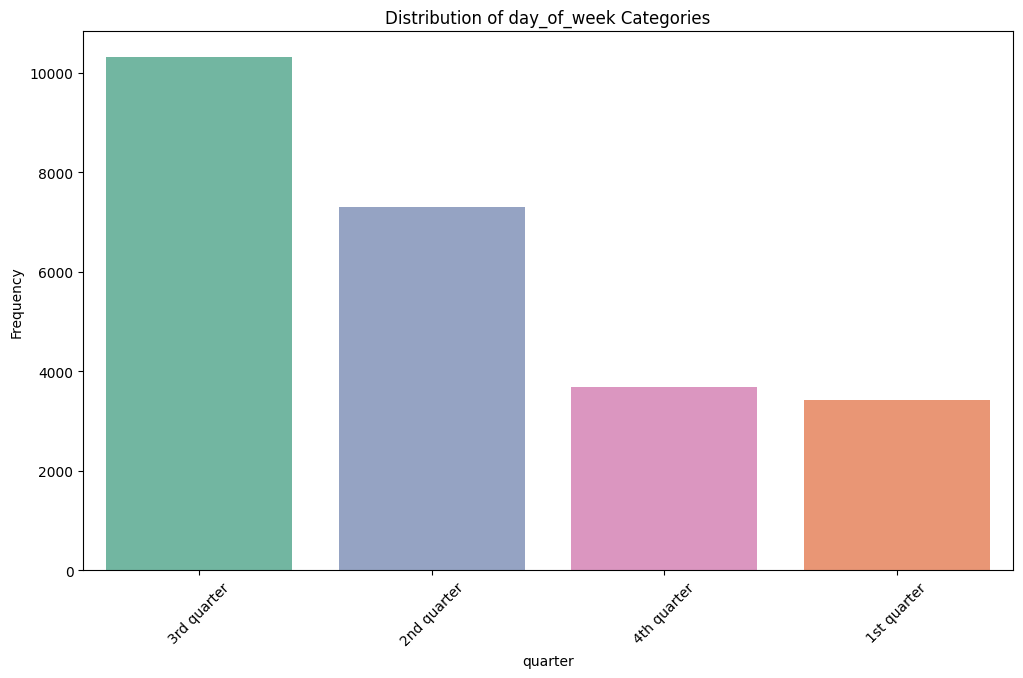

In [ ]:
# Create the bar plot adjusting for the seaborn update

order = Train_Xy['quarter'].value_counts().index

plt.figure(figsize=(12, 7))
ax = sns.countplot(x='quarter', data=Train_Xy, hue='quarter', order = order, palette='Set2', dodge=False)

# Check if the legend exists before removing it
legend = ax.get_legend()
if legend:
    legend.remove()

# Add title and labels
plt.title('Distribution of day_of_week Categories')
plt.xlabel('quarter')
plt.ylabel('Frequency')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

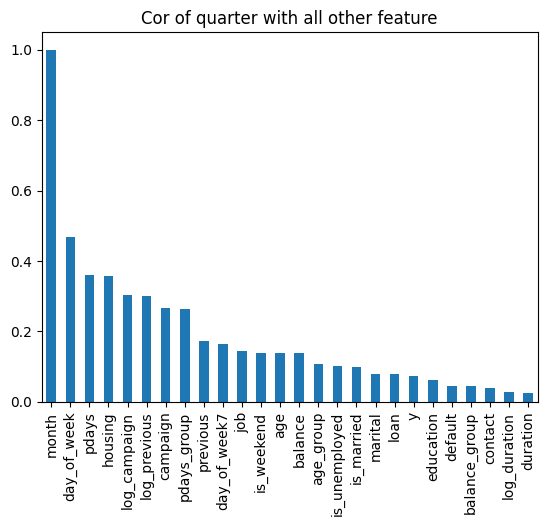

In [ ]:
plt.figure()
assoc.loc["quarter"].drop(["quarter"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of quarter with all other feature")
plt.show()

### Duration column

This is in sec and converted to min to reduce the scale

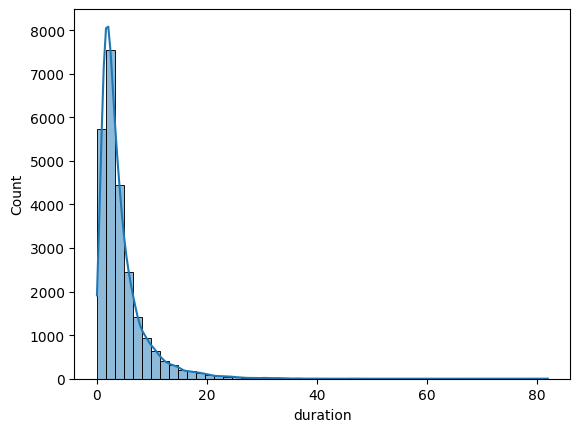

In [ ]:
sns.histplot(Train_Xy["duration"]/60, bins=50, kde=True)
plt.show()


Log transformation

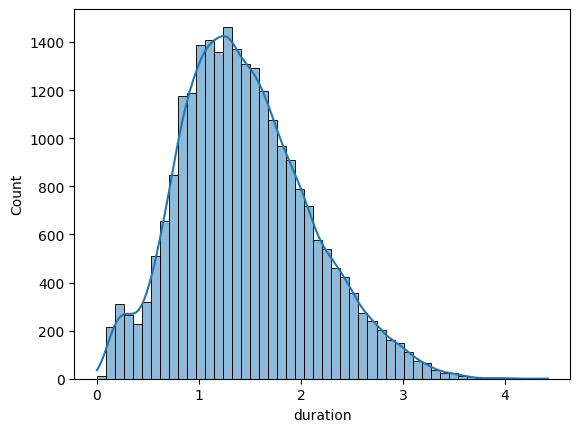

In [ ]:
sns.histplot(np.log1p(Train_Xy["duration"]/60), bins=50, kde=True)
plt.show()

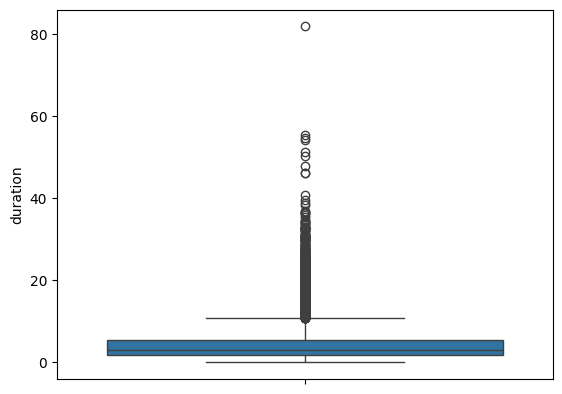

In [ ]:
sns.boxplot(Train_Xy["duration"]/60)
plt.show()

Duration is a very good predictor of the target variable

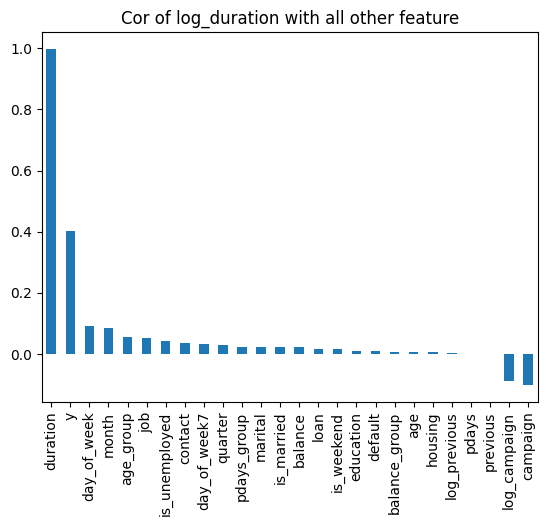

In [ ]:
plt.figure()
assoc.loc["log_duration"].drop(["log_duration"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of log_duration with all other feature")
plt.show()

### Campaign column

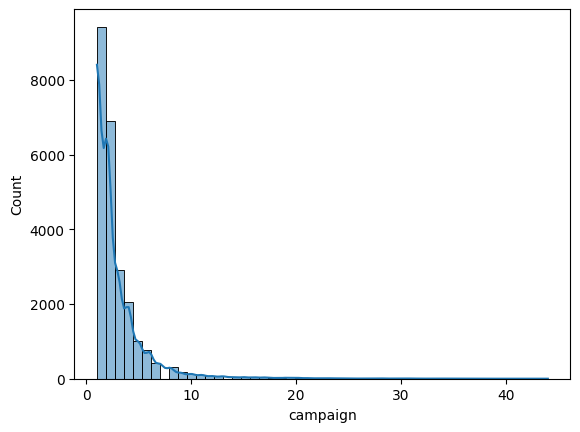

In [ ]:
sns.histplot(Train_Xy["campaign"], bins=50, kde=True)
plt.show()


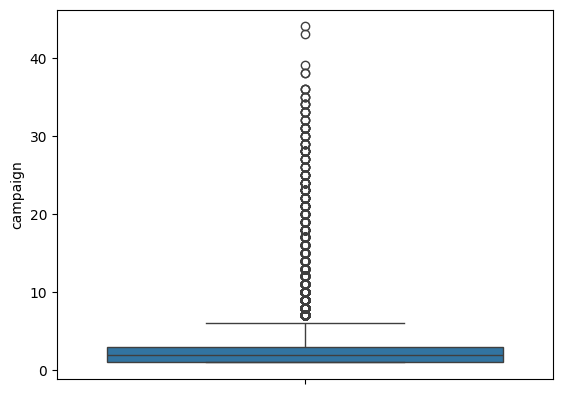

In [ ]:
sns.boxplot(Train_Xy["campaign"])
plt.show()

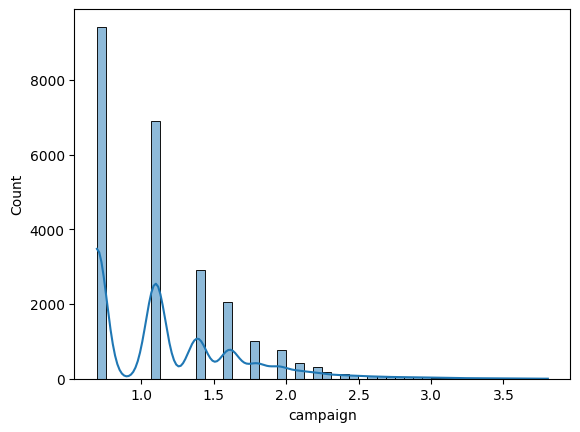

In [ ]:
# from sklearn.preprocessing import PowerTransformer
# power = PowerTransformer(method='box-cox', standardize=True)
# data = Train_Xy["campaign"].to_numpy().reshape(-1, 1)
# print(type(data), data.shape)
# data_trans = power.fit_transform(data)
data_trans = np.log1p(Train_Xy["campaign"])
sns.histplot(data_trans, bins=50, kde=True)
plt.show()


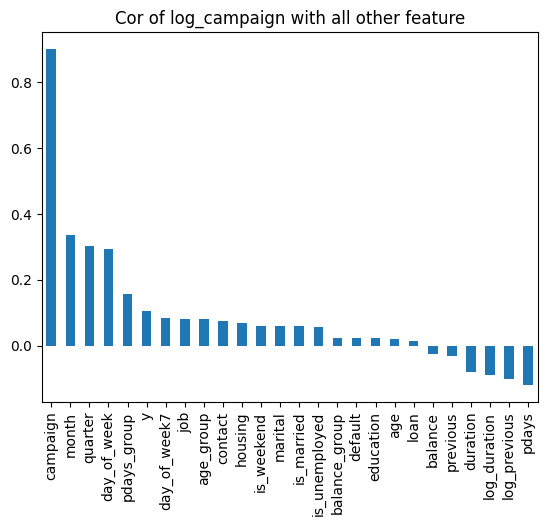

In [ ]:
plt.figure()
assoc.loc["log_campaign"].drop(["log_campaign"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of log_campaign with all other feature")
plt.show()

### Pdays column

-1 value means the client has not been previously contacted

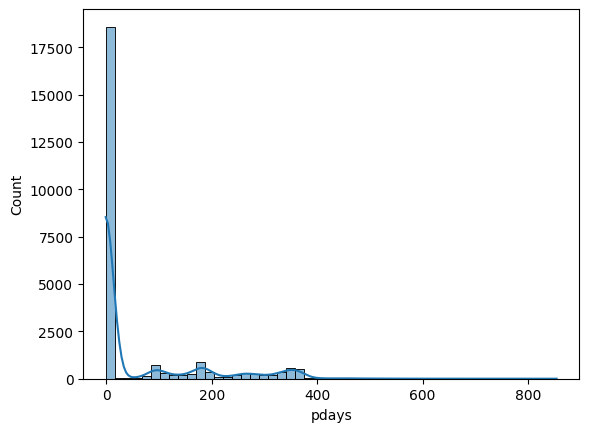

In [ ]:
sns.histplot(Train_Xy["pdays"], bins=50, kde=True)
plt.show()

<Axes: xlabel='pdays_group'>

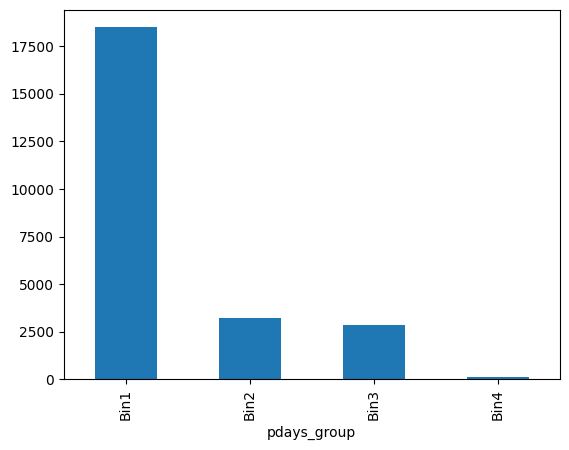

In [ ]:
bins = [-1, 0, 200, 400, float('inf')]
labels = ['Bin1', 'Bin2', 'Bin3', 'Bin4']
# Bin the balance values
Train_Xy['pdays_group'] = pd.cut(Train_Xy['pdays'], bins=bins, labels=labels, right=False)


Train_Xy['pdays_group'].value_counts().plot(kind='bar')

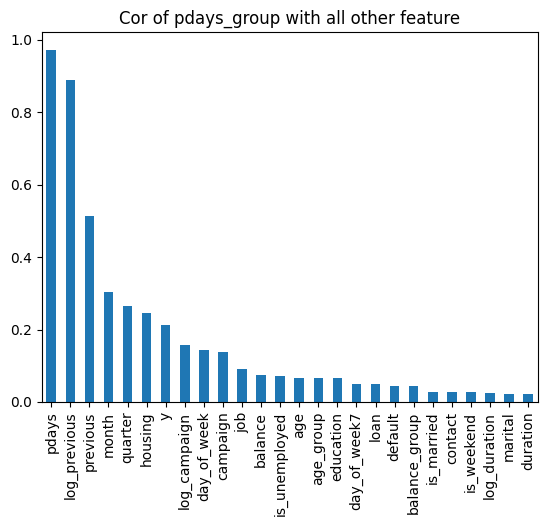

In [ ]:
plt.figure()
assoc.loc["pdays_group"].drop("pdays_group").sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of pdays_group with all other feature")
plt.show()

### Previous column

This is multi-modal so we apply rbf

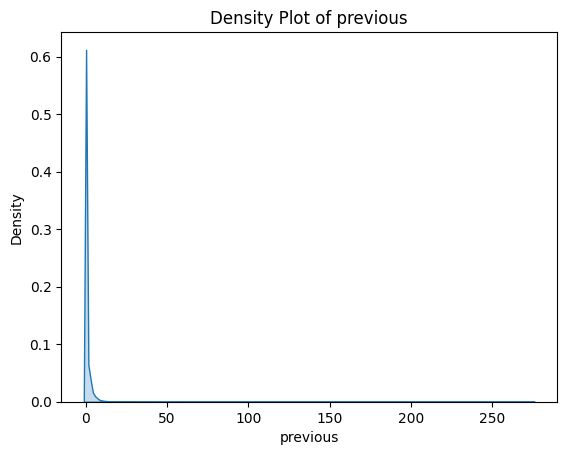

In [ ]:
sns.kdeplot(Train_Xy['previous'], fill=True)
plt.title('Density Plot of previous')
plt.xlabel('previous')
plt.ylabel('Density')
plt.show()

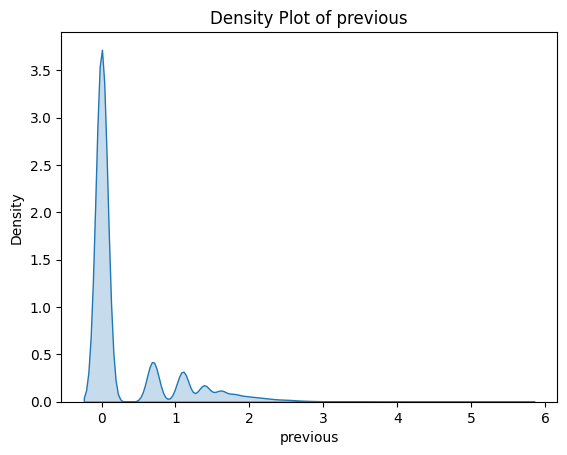

In [ ]:
# Create a density plot
sns.kdeplot(np.log1p(Train_Xy['previous']), fill=True)
plt.title('Density Plot of previous')
plt.xlabel('previous')
plt.ylabel('Density')
plt.show()

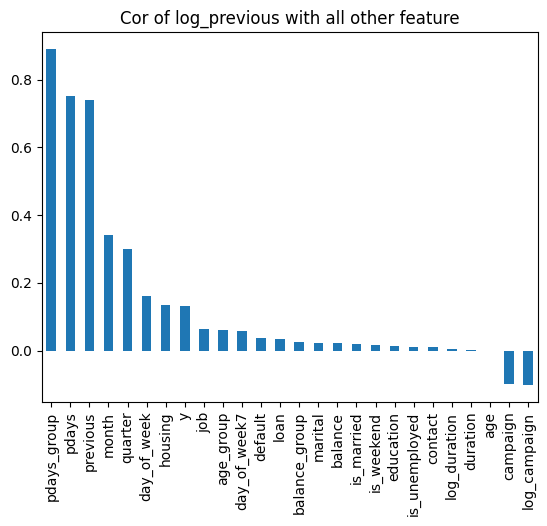

In [ ]:
plt.figure()
assoc.loc["log_previous"].drop(["log_previous"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of log_previous with all other feature")
plt.show()

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

ab = rbf_kernel(Train_Xy[['previous']])
sns.kdeplot(ab, fill=True)
plt.title('Density Plot of previous')
plt.xlabel('previous')
plt.ylabel('Density')
plt.show()

In [ ]:
# Train_Xy["poutcome"].value_counts(normalize=True)

## Target variable

In [ ]:
Train_Xy["y"].value_counts(normalize=True)

y
no     0.853994
yes    0.146006
Name: proportion, dtype: float64

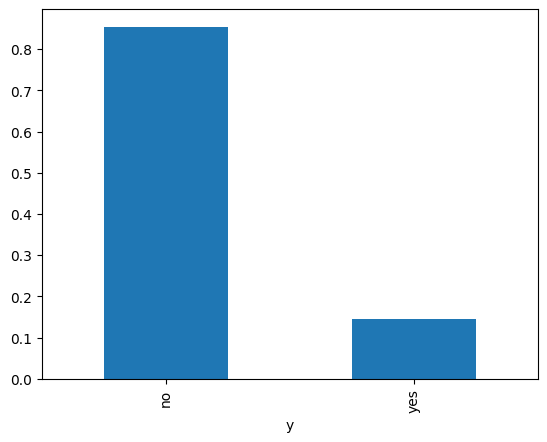

In [ ]:
Train_Xy["y"].value_counts(normalize=True).plot(kind="bar")
plt.show()

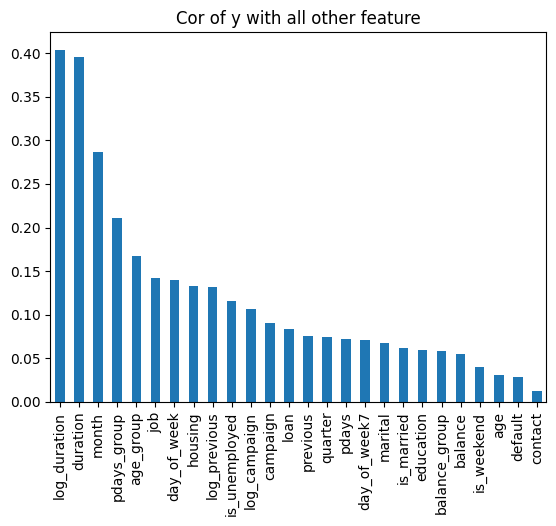

In [ ]:
plt.figure()
assoc.loc["y"].drop(["y"]).sort_values(ascending=False).plot(kind="bar")
plt.title("Cor of y with all other feature")
plt.show()

## **4. Construct Data**

After studying the individual features, we apply some log transformation, one-hot encoded some and agglomerate some features to reduce model complexity (to avoid the curse of dimensionality).

In [ ]:
def prepare_train_test_data():

  input_features, target_feature = load_data_from_uci()

  Xy = pd.concat([input_features, target_feature], axis = 1)
  Xy['uuid'] = [uuid.uuid4() for _ in range(len(Xy))]
  Xy.drop(columns=["poutcome"], inplace=True)
  Xy.dropna(axis=0, inplace=True)

  Train_Xy, Test_Xy = train_test_split(Xy,
                                      test_size = TEST_PORTION,
                                      stratify=Xy[TARGET_COL],
                                      random_state = RANDOM_STATE)

  Train_Xy_uuid = Train_Xy['uuid']
  Test_Xy_uuid = Test_Xy['uuid']

  return Train_Xy, Test_Xy, Train_Xy_uuid, Test_Xy_uuid

Train_Xy, Test_Xy, Train_Xy_uuid, Test_Xy_uuid = prepare_train_test_data()

In [ ]:
Train_Xy["duration"] = Train_Xy["duration"]/60

Train_Xy["is_unemployed"] = Train_Xy["job"].isin(["unemployed", "student", "retired"]).astype(object)
Train_Xy["is_married"] = (Train_Xy["marital"] == "married").astype(object)
Train_Xy["day_of_week"] = Train_Xy["day_of_week"].apply(map_to_weekday).astype(object)
Train_Xy["is_weekend"] = Train_Xy["day_of_week"].isin([6, 7]).astype(object)
# Map each month to its respective quarter
month_to_quarter = {
  'jan': '1st quarter', 'feb': '1st quarter', 'mar': '1st quarter',
  'apr': '2nd quarter', 'may': '2nd quarter', 'jun': '2nd quarter',
  'jul': '3rd quarter', 'aug': '3rd quarter', 'sep': '3rd quarter',
  'oct': '4th quarter', 'nov': '4th quarter', 'dec': '4th quarter'
}

Train_Xy['quarter'] = Train_Xy['month'].map(month_to_quarter)

bins = [0, 20, 30, 45, 60, np.inf]
labels = ['<20', '20-30', '30-45', '45-60', '60+']
Train_Xy['age_group'] = pd.cut(Train_Xy['age'], bins=bins, labels=labels, right=False).astype(object)

bins = [-float('inf'), -10000, -5000, 0, 20000, 40000, float('inf')]
labels = ['Extremely Negative','Very Negative', 'Negative', 'Low', 'Medium', 'High']
# Bin the balance values
Train_Xy['balance_group'] = pd.cut(Train_Xy['balance'], bins=bins, labels=labels, right=False).astype(object)

bins = [-1, 0, 200, 400, float('inf')]
labels = ['Bin1', 'Bin2', 'Bin3', 'Bin4']
# Bin the balance values
Train_Xy['pdays_group'] = pd.cut(Train_Xy['pdays'], bins=bins, labels=labels, right=False).astype(object)

Train_Xy['log_duration'] = np.log1p(Train_Xy['duration'])  # np.log1p is used to handle zero values smoothly
Train_Xy["log_campaign"] = np.log1p(Train_Xy["campaign"])
Train_Xy['log_previous'] = np.log1p(Train_Xy['previous'])  # np.log1p is used to handle zero values smoothly

drop_feature = ["age", "marital", "education", "default", "housing", "loan", "contact", "month", 'duration', "job", "balance", "pdays", "day_of_week", "previous", "month", "campaign", 'uuid']

Train_Xy.drop(columns=drop_feature, inplace=True)

Train_Xy.y = (Train_Xy.y == 'yes').astype(int)

Train_Xy.select_dtypes(include=["object"]).columns.to_list()

['is_unemployed',
 'is_married',
 'is_weekend',
 'quarter',
 'age_group',
 'balance_group',
 'pdays_group']

### Evaluating Feature importance categorical variables after feature engineering: Risk Ratio

This is done using the risk ratio and difference. All categories with risk ratio less than one are more likely not to subscribe more than the global average hence should be targeted. For instance in the balance group, people with high balance are more likely to subscribe

In [ ]:
global_churn = Train_Xy.y.mean()

categorical= Train_Xy.select_dtypes(include=["object"]).columns.to_list()

for c in categorical:
    print(c)
    df_group = Train_Xy.groupby(c).y.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()


is_unemployed


,mean,count,diff,risk
is_unemployed,,,,
False,0.131831,22104,-0.014175,0.902917
True,0.265548,2621,0.119541,1.818743




is_married


,mean,count,diff,risk
is_married,,,,
False,0.171596,10041,0.025590,1.175269
True,0.128507,14684,-0.017499,0.880150




is_weekend


,mean,count,diff,risk
is_weekend,,,,
False,0.156207,16779,0.010201,1.069868
True,0.124465,7946,-0.021541,0.852466




quarter


,mean,count,diff,risk
quarter,,,,
1st quarter,0.180888,3422,0.034882,1.238910
2nd quarter,0.164888,7308,0.018882,1.129322
3rd quarter,0.113826,10314,-0.032180,0.779597
4th quarter,0.166259,3681,0.020253,1.138714




age_group


,mean,count,diff,risk
age_group,,,,
20-30,0.218881,2860,0.072875,1.499123
30-45,0.125833,13359,-0.020173,0.861832
45-60,0.118707,7329,-0.027300,0.813024
60+,0.367507,1151,0.221500,2.517063
<20,0.384615,26,0.238609,2.634242




balance_group


,mean,count,diff,risk
balance_group,,,,
High,0.235294,17,0.089288,1.611537
Low,0.151612,22828,0.005606,1.038396
Medium,0.212766,94,0.066760,1.457241
Negative,0.070067,1784,-0.075939,0.479893
Very Negative,0.000000,2,-0.146006,0.000000




pdays_group


,mean,count,diff,risk
pdays_group,,,,
Bin1,0.118134,18479,-0.027872,0.809104
Bin2,0.314912,3239,0.168906,2.156842
Bin3,0.112627,2859,-0.033379,0.771384
Bin4,0.574324,148,0.428318,3.933565


### Evaluating Feature importance categorical variables after feature engineering: Mutual information

The most important feature is the pdays_group (number of days that passed by after the client was last contacted from a previous campaign) and is the best indicator of wheter a customer will subscribe or not. It also has the highest average risk ratio. By looking also at the correlation plot, the same message is conveyed

In [ ]:
from sklearn.metrics import mutual_info_score

mutual_info_score(Train_Xy.y, Train_Xy.age_group)


0.011177847134138509

In [ ]:
mi = {}
for c in categorical:
  mi[c] = [mutual_info_score(Train_Xy.y, Train_Xy[c])]

mi

{'is_unemployed': [0.005837580284845115],
 'is_married': [0.0017740485753741653],
 'is_weekend': [0.0009023073870406823],
 'quarter': [0.0031317315210962204],
 'age_group': [0.011177847134138509],
 'balance_group': [0.0022121826050482034],
 'pdays_group': [0.01788401044289968]}

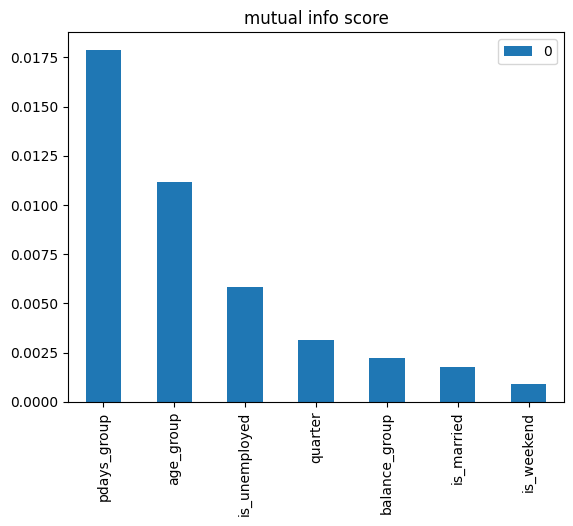

In [ ]:
df = pd.DataFrame.from_dict(mi)
df.T.sort_values(ascending=False, by=0).plot(kind="bar", title="mutual info score")
plt.show()

### Evaluating Feature importance numerical variables after feature engineering: Correlation

Already implemented

# **Feature Engineering**

1. Generate Test/Train sets
2. Feature Creation / Tansformation / Encoding / Scaling

#### 1. Generate Test/Train sets


In [ ]:
# input_features, target_feature = load_data_from_uci()

# Xy = pd.concat([input_features, target_feature], axis = 1)
# Xy.drop(columns=["poutcome"], inplace=True)
# Xy.dropna(axis=0, inplace=True)

# # removing outliers
# lower_limit, upper_limit = np.percentile(a=Xy["age"],q=[0.5,99.5])
# outlier1 = ((Xy["age"]<lower_limit) | (Xy["age"]>upper_limit))

# lower_limit2, upper_limit2 = np.percentile(a=Xy["balance"],q=[0.5,99.5])
# outlier2 = ((Xy["balance"]<lower_limit2) | (Xy["balance"]>upper_limit2))

# lower_limit3, upper_limit3 = np.percentile(a=Xy["duration"],q=[0.5,99.5])
# outlier3 = ((Xy["duration"]<lower_limit3) | (Xy["duration"]>upper_limit3))

# lower_limit4, upper_limit4 = np.percentile(a=Xy["campaign"],q=[0.5,99.5])
# outlier4 = ((Xy["campaign"]<lower_limit4) | (Xy["campaign"]>upper_limit4))

# lower_limit5, upper_limit5 = np.percentile(a=Xy["pdays"],q=[0.5,99.5])
# outlier5 = ((Xy["pdays"]<lower_limit5) | (Xy["pdays"]>upper_limit5))

# lower_limit6, upper_limit6 = np.percentile(a=Xy["previous"],q=[0.5,99.5])
# outlier6 = ((Xy["previous"]<lower_limit6) | (Xy["previous"]>upper_limit6))

# outlier = outlier1 | outlier2 | outlier3 | outlier4 | outlier5 | outlier6

# Xy = Xy[~outlier]

# print(np.sum(outlier))


1266


In [ ]:
Train_Xy, Test_Xy, Train_Xy_uuid, Test_Xy_uuid = prepare_train_test_data()


# Determine X and y

def make_x_y(Xy, target_col, drop_col=None):
  """

  Args:
    Xy:
    target_col:

  Returns:

  """
  Xy = Xy.drop(columns = drop_col)
  X = Xy.drop(columns = [target_col])
  y = Xy[target_col]
  return X,y


Train_X, Train_y = make_x_y(Xy = Train_Xy, target_col = TARGET_COL, drop_col = ['uuid'])
Test_X, Test_y = make_x_y(Xy = Test_Xy, target_col = TARGET_COL, drop_col = ['uuid'])

Train_X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous
14898,47,blue-collar,divorced,secondary,no,25,no,yes,cellular,16,jul,81,6,-1,0
30894,40,management,married,secondary,no,99,no,no,cellular,9,feb,15,5,-1,0
21168,59,retired,married,secondary,no,385,no,yes,telephone,14,aug,365,2,-1,0
39353,31,blue-collar,single,secondary,no,707,yes,no,cellular,18,may,52,2,-1,0
45170,19,student,single,primary,no,245,no,no,telephone,10,nov,98,2,110,2


### 2. Feature Creation / Tansformation / Encoding / Scaling

In [ ]:
# Feature creation and transformation
# data_input['days_since_last_contact_imputed'] = data_input['pdays'].replace(-1, 0)

class CustomFeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, add_log_transform=True):
        self.add_log_transform = add_log_transform

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assume X is a DataFrame
        X = X.copy()
        X["duration"] = X["duration"]/60

        X["is_unemployed"] = X["job"].isin(["unemployed", "student", "retired"]).astype(int)
        X["is_married"] = (X["marital"] == "married").astype(int)
        X["day_of_week"] = X["day_of_week"].apply(map_to_weekday).astype(int)
        X["is_weekend"] = X["day_of_week"].isin([6, 7]).astype(int)
        # Map each month to its respective quarter
        month_to_quarter = {
          'jan': '1st quarter', 'feb': '1st quarter', 'mar': '1st quarter',
          'apr': '2nd quarter', 'may': '2nd quarter', 'jun': '2nd quarter',
          'jul': '3rd quarter', 'aug': '3rd quarter', 'sep': '3rd quarter',
          'oct': '4th quarter', 'nov': '4th quarter', 'dec': '4th quarter'
        }

        X['quarter'] = X['month'].map(month_to_quarter)

        bins = [0, 20, 30, 45, 60, np.inf]
        labels = ['<20', '20-30', '30-45', '45-60', '60+']
        X['age_group'] = pd.cut(X['age'], bins=bins, labels=labels, right=False)

        bins = [-float('inf'), -10000, -5000, 0, 20000, 40000, float('inf')]
        labels = ['Extremely Negative','Very Negative', 'Negative', 'Low', 'Medium', 'High']
        # Bin the balance values
        X['balance_group'] = pd.cut(X['balance'], bins=bins, labels=labels, right=False)

        bins = [-1, 0, 200, 400, float('inf')]
        labels = ['Bin1', 'Bin2', 'Bin3', 'Bin4']
        # Bin the balance values
        X['pdays_group'] = pd.cut(X['pdays'], bins=bins, labels=labels, right=False)




        # Adding log transformation for capital-gain
        if self.add_log_transform:
            X['log_duration'] = np.log1p(X['duration'])  # np.log1p is used to handle zero values smoothly
            X["log_campaign"] = np.log1p(X["campaign"])
            X['log_previous'] = np.log1p(X['previous'])  # np.log1p is used to handle zero values smoothly

        return X


num = ["log_campaign", "log_duration", 'log_previous']

# cat = ["education", "default", "housing", "loan", "contact", "month", "day_of_week"]
cat = ["education", "loan", "quarter", 'age_group', 'balance_group', 'pdays_group']

binary_features = ["is_unemployed", "is_married",  "is_weekend"]

drop_feature = ["age", "marital", "education", "default", "housing", "loan", "contact", "month", 'duration', "job", "balance", "pdays", "day_of_week", "previous", "month", "campaign", ]

# feature scaling and encoding

# Setting up ColumnTransformer

feature_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num), # scaling numerical input variables
        ('cat', OneHotEncoder(sparse_output=False, drop="first"), cat), # encoding categorical input variables
        ('binary', 'passthrough', binary_features), # skip these features
        ('transformed', 'drop', drop_feature) # drop these features
    ],
    remainder='passthrough'
)

# feature_transformer = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), num), # scaling numerical input variables
#         ('preprocessor', PolynomialFeatures(degree=2, include_bias=False), num),
#         ('cat', OneHotEncoder(sparse_output=False, drop="first"), cat), # encoding categorical input variables
#         ('binary', 'passthrough', binary_features), # skip these features
#         ('transformed', 'drop', drop_feature) # drop these features
#     ],
#     remainder='passthrough'
# )

# Feature Engineering
feature_engineering_pipeline = Pipeline(steps=[
    ('feature_creation', CustomFeatureCreator()), # create feature
    ('feature_transform', feature_transformer) # transform features
])



# Apply the feature engineering pipeline
feature_engineering_pipeline.fit(Train_X)
label_encoder = LabelEncoder().fit(Train_y)

Train_X_transformed = feature_engineering_pipeline.transform(Train_X)
Train_y_transformed = label_encoder.transform(Train_y)

Test_X_transformed = feature_engineering_pipeline.transform(Test_X)
Test_y_transformed = label_encoder.transform(Test_y)


In [ ]:
Train_X_transformed.shape, Test_X_transformed.shape, Train_y_transformed.shape, Test_y_transformed.shape

((24725, 23), (6182, 23), (24725,), (6182,))

In [ ]:
np.isnan(Test_X_transformed)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
feature_transformer.get_feature_names_out()

array(['num__log_campaign', 'num__log_duration', 'num__log_previous',
       'cat__education_secondary', 'cat__education_tertiary',
       'cat__loan_yes', 'cat__quarter_2nd quarter',
       'cat__quarter_3rd quarter', 'cat__quarter_4th quarter',
       'cat__age_group_30-45', 'cat__age_group_45-60',
       'cat__age_group_60+', 'cat__age_group_<20',
       'cat__balance_group_Low', 'cat__balance_group_Medium',
       'cat__balance_group_Negative', 'cat__balance_group_Very Negative',
       'cat__pdays_group_Bin2', 'cat__pdays_group_Bin3',
       'cat__pdays_group_Bin4', 'binary__is_unemployed',
       'binary__is_married', 'binary__is_weekend'], dtype=object)

# **Modelling**

1. Select Modelling Technique
2. Build Model
3. Assess Model
4. Feature Evaluation & Selection


## **1.Select Modelling Technique**

Different models have their strengths and weakness hence different models will be explored. As argued in the lecture notes, random forest will be chosen as a base model for its robustness, versatility, and generally high performance across a wide range of data types and tasks.

In [ ]:
# compare models using cross validation
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb



## **2. Build Model**

The following models were explored:

1. Logistic regression
2. Random forest
3. K nearest neighbour
4. Simple decision tree
5. Ada boost
6. Stochastic gradient classifier
7. Support vector machine
8. Gradient Boosting

## **3. Assess Model: Out-of-Box performance**

Due to the class imbalance of the terget variable, accuracy as metric is not ideal. Depending on the use case, we can use either the precision or recall as a metric.

If for instance, we use the weighted average of the f1-score as a metric, f1-score on the training set is 1 and 0.87 on the test set. The model generalises well on the unseen test set.

There are signs of mild overfitting and hence the model can be fine tuned further to generalise better.


In [ ]:
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

log_reg_model.fit(Train_X_transformed, Train_y_transformed)

# Predictions
y_pred = log_reg_model.predict(Test_X_transformed)
y_proba = log_reg_model.predict_proba(Test_X_transformed)

TARGET_NAMES = Train_y.unique().tolist()
print(classification_report(Test_y_transformed, y_pred, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

          no       0.89      0.97      0.93      5279
         yes       0.62      0.30      0.41       903

    accuracy                           0.87      6182
   macro avg       0.76      0.64      0.67      6182
weighted avg       0.85      0.87      0.85      6182



 Recall expresses the ability to find all relevant instances of a class in a data set. Eg:  “Out of all the actual spam emails, what proportion did the system correctly identify?”

 Precision focuses on the correctness of positive predictions. Eg: “Out of all the emails flagged as spam, what proportion were actually spam?”

 $$p = tp / (tp + fp)$$

 $$r = tp / (tp + fn)$$




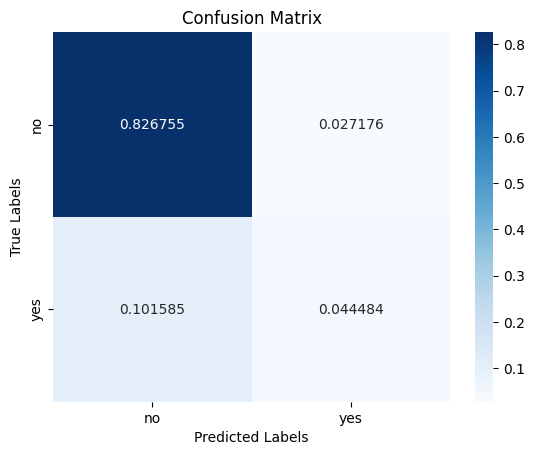

In [ ]:
# gives the breakdown of the above result into tp, tn, fp, and fn as seen in the heatmap below
cm = confusion_matrix(Test_y_transformed, y_pred)
tot = cm.sum()
cm= cm/tot
sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
lr_auc = roc_auc_score(Test_y_transformed, y_proba[:,1]) # good for balance datasets
lr_auc


0.867004116060271

In [ ]:
precision, recall, thresholds = precision_recall_curve(Test_y_transformed, y_proba[:,1])
auprc = auc(recall, precision)
auprc

0.5209765477781046

In [ ]:
f1 = f1_score(Test_y_transformed, y_pred) # not a good metrics for imbalance datasets
f1

0.4086181277860327

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf.fit(Train_X_transformed, Train_y_transformed)

# Predictions
y_pred2 = rf.predict(Test_X_transformed)
y_proba2 = rf.predict_proba(Test_X_transformed)

TARGET_NAMES = Train_y.unique().tolist()
print(classification_report(Test_y_transformed, y_pred2, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

          no       0.90      0.94      0.92      5279
         yes       0.50      0.37      0.42       903

    accuracy                           0.85      6182
   macro avg       0.70      0.65      0.67      6182
weighted avg       0.84      0.85      0.84      6182



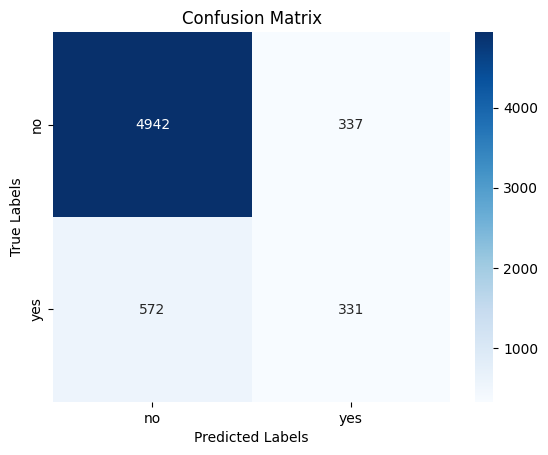

In [ ]:
# gives the breakdown of the above result into tp, tn, fp, and fn as seen in the heatmap below
cm = confusion_matrix(Test_y_transformed, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
rf_auc = roc_auc_score(Test_y_transformed, y_proba2[:,1])
rf_auc


0.8407107121407311

In [ ]:
precision, recall, thresholds = precision_recall_curve(Test_y_transformed, y_proba2[:,1])
auprc = auc(recall, precision)
auprc

0.4316189047880281

## **4. Cross Validation**

To reduce any biases of the model performance from the data, we apply cross validation. This helps in making a choice of a model. In this case random forest has the highest validation score hence the plausible choice as a model for further fine tuning

In [ ]:

# instantiate model
svm_clf = SVC(gamma="auto", random_state=42)
rf_model = RandomForestClassifier(random_state=42)
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
dt = DecisionTreeClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
ad = AdaBoostClassifier(random_state=42)
xg = xgb.XGBClassifier()


score = []
models = [svm_clf, rf_model, log_reg_model, sgd_clf, knn, dt, gb, ad, xg]
for model in models:
  mn = cross_val_score(model, Train_X_transformed, Train_y_transformed, cv=5, scoring="f1_weighted").mean()
  score.append(mn)

print(score)

[0.8242809310052059, 0.8439996675462409, 0.8457049148721595, 0.7994928628214125, 0.8370872195804363, 0.8215759257155106, 0.8559729684448678, 0.8438100670183661, 0.8548905150461102]


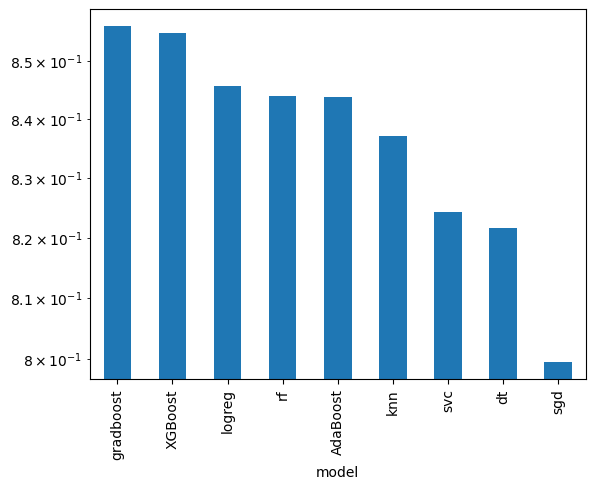

In [ ]:
# best model is random forest
keys = ["svc", "rf", "logreg", "sgd", "knn", "dt", "gradboost", "AdaBoost", "XGBoost"]
pd.DataFrame(zip(keys,score), columns=["model", "f1"]).set_index("model").sort_values(by ="f1", ascending=False).plot(kind="bar", legend=False)
plt.yscale("log")
plt.show()

## **4. Feature Selection/Importance**

Below, is shown the feature importances in descending order. this helps in the model interpretability or explainability. The most important feature here is the last contact "duration" and the average yearly "balance". That is to say the the key determinant for a subscriber is the how much time the bank spend talking to the client and the amount of money they have their bank account.

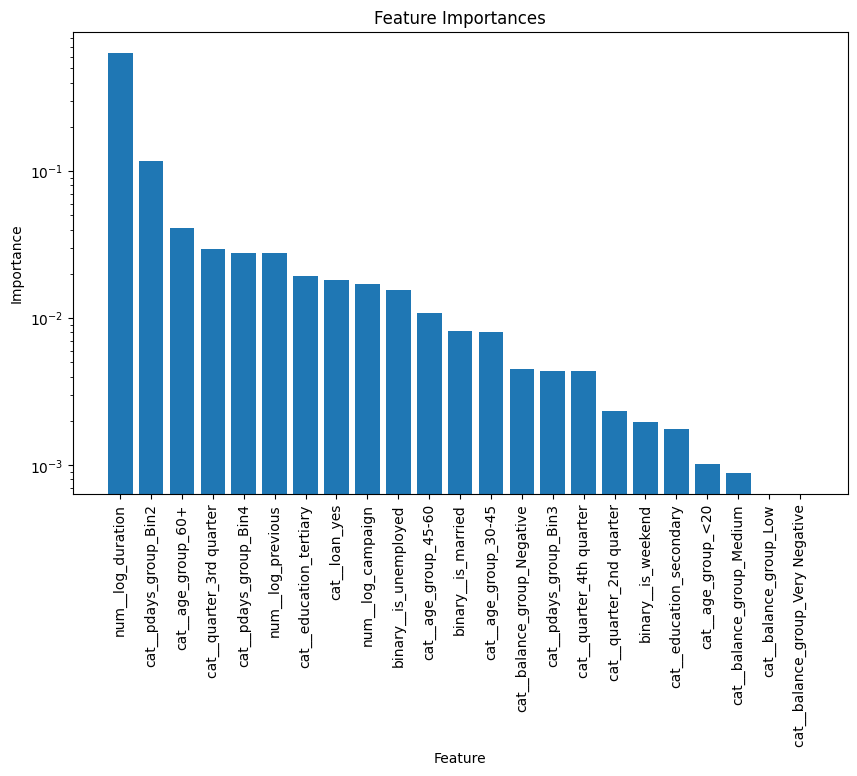

In [ ]:
# model_ = RandomForestClassifier(random_state=42)
model = GradientBoostingClassifier(random_state=42)

model.fit(Train_X_transformed, Train_y_transformed)


# Get feature importances
importances = model.feature_importances_

# If using ColumnTransformer or Pipeline, ensure you adjust this part to accurately reflect feature names.
# Here is an example assuming you know the feature names:
feature_names = feature_transformer.get_feature_names_out()  # Replace with your actual feature names

# Sort feature importances in descending order and create labels
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[idx] for idx in indices]
sorted_importances = importances[indices]

# Create the plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.yscale("log")

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
